In [1]:
import sys 
sys.path.append('/Users/patroklos/Desktop/delphi_')

import torch as ch
from torch import Tensor
from torch.distributions import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence

import seaborn as sns
import matplotlib.pyplot as plt
import IPython 

from delphi.distributions.normal import CensoredNormal
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader

In [29]:
args = Parameters({ 
    'samples': 1000, 
    'batch_size': 1, 
    'tol': 1e-1, 
    'lr': 1e-1, 
    'out_dir': '/Users/patroklos/Desktop/exp',
    'exp': 'censored_adjust_loc', 
    'trials': 20,
    'var': 10,
    'table_name': 'logs',
})

Synthetic Data Experiment for 1 Dimensional Censored Gaussian Distributions 

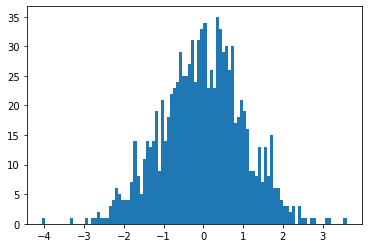

In [3]:
M = MultivariateNormal(Tensor([0.0]), 1.0*ch.ones(1, 1))
samples = M.sample([args.samples])

plt.hist(samples.flatten(), bins=100)
plt.show()

Truncate the Dataset

alpha: 0.499


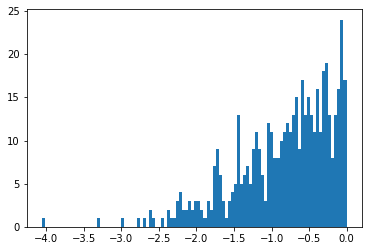

In [15]:
phi = oracle.Right(Tensor([0.0]))
# phi = oracle.Identity()
indices = phi(samples).nonzero()[:,0]
S = samples[indices]
alpha = S.size(0) / samples.size(0)
print("alpha: {}".format(alpha))

plt.hist(S.flatten(), bins=100)
plt.show()

In [16]:
emp_loc = S.mean(0)
print("empirical mean: ", emp_loc)
emp_scale = ch.sqrt(S.var(0))
print("empirical scale: ", emp_scale)

S_norm = (S - emp_loc) / emp_scale
phi_norm = oracle.Right((phi.right - emp_loc) / emp_scale)

empirical mean:  tensor([-0.8391])
empirical scale:  tensor([0.6485])


Run algorithm to Remove Bias from the Dataset

In [17]:
censored = CensoredNormal(phi=phi_norm, 
                          alpha=alpha, 
                          iter_=2, 
                          bs=10, 
                          num_samples=10,
#                           step_lr=100,
#                           step_lr=50,
                          lr=1e-1)
#                           custom_lr_multiplier='adam')
censored.fit(S_norm)

mu: tensor([0.0078])
cov: tensor([[1.0187]])
num samples:  tensor(9)
num samples:  tensor(9)
cov grad: tensor([[0.1461]])
loc grad: tensor([-0.3839])
mu: tensor([0.0476])
cov: tensor([[1.0341]])
num samples:  tensor(9)
num samples:  tensor(8)
cov grad: tensor([[0.0266]])
loc grad: tensor([-0.7277])
mu: tensor([0.1232])
cov: tensor([[1.0369]])
num samples:  tensor(7)
num samples:  tensor(8)
cov grad: tensor([[0.5731]])
loc grad: tensor([0.3701])
mu: tensor([0.0902])
cov: tensor([[1.1025]])
num samples:  tensor(10)
cov grad: tensor([[0.1990]])
loc grad: tensor([-0.0633])
mu: tensor([0.0994])
cov: tensor([[1.1272]])
num samples:  tensor(9)
num samples:  tensor(10)
cov grad: tensor([[-0.3521]])
loc grad: tensor([0.2186])
mu: tensor([0.0719])
cov: tensor([[1.0842]])
num samples:  tensor(10)
cov grad: tensor([[0.0221]])
loc grad: tensor([0.1003])
mu: tensor([0.0611])
cov: tensor([[1.0868]])
num samples:  tensor(8)
num samples:  tensor(9)
cov grad: tensor([[-0.1906]])
loc grad: tensor([-0.792

num samples:  tensor(5)
cov grad: tensor([[0.2011]])
loc grad: tensor([0.1258])
mu: tensor([1.2371])
cov: tensor([[2.8752]])
num samples:  tensor(5)
num samples:  tensor(4)
num samples:  tensor(4)
cov grad: tensor([[0.1830]])
loc grad: tensor([0.6410])
mu: tensor([1.1113])
cov: tensor([[3.0349]])
num samples:  tensor(7)
num samples:  tensor(6)
cov grad: tensor([[-0.2420]])
loc grad: tensor([-0.0679])
mu: tensor([1.0545])
cov: tensor([[2.8273]])
num samples:  tensor(2)
num samples:  tensor(4)
num samples:  tensor(4)
cov grad: tensor([[0.0476]])
loc grad: tensor([-0.7518])
mu: tensor([1.2843])
cov: tensor([[2.8659]])
num samples:  tensor(3)
num samples:  tensor(4)
num samples:  tensor(5)
cov grad: tensor([[-0.6082]])
loc grad: tensor([-0.9891])
mu: tensor([1.3351])
cov: tensor([[2.4405]])
num samples:  tensor(1)
num samples:  tensor(6)
num samples:  tensor(3)
cov grad: tensor([[0.5612]])
loc grad: tensor([0.5279])
mu: tensor([1.3977])
cov: tensor([[2.8278]])
num samples:  tensor(2)
num s

In [18]:
censored.loc * emp_scale + emp_loc

tensor([-0.1455])

In [19]:
censored.variance * emp_scale.pow(2)

tensor([[0.9386]])

In [37]:
store = Store(args.out_dir + '/' + args.exp)

schema = { 
    'kl_div_emp': float, 
    'kl_div_censored': float,
    'var': int,
    'alpha': float,
}

store.add_table(args.table_name, schema)

for i in range(args.trials): 
    gt_loc = Uniform(-1, 1).sample([1,])
    for var in range(1, args.var + 1):
        # create new dataset
        gt_scale = var * ch.ones(1, 1)
        gt_dist = MultivariateNormal(gt_loc, gt_scale)
        samples = gt_dist.sample([args.samples])

        # right truncate at 0
        phi = oracle.Right(Tensor([0.0]))
        indices = phi(samples).nonzero()[:,0]
        S = samples[indices]
        alpha = S.size(0) / samples.size(0)

        emp_dist = MultivariateNormal(S.mean(0), S.var(0) * ch.ones(1, 1))

        S_norm = (S - emp_dist.loc) / ch.sqrt(emp_dist.covariance_matrix) 
        phi_norm = oracle.Right((phi.right - emp_dist.loc) / ch.sqrt(emp_dist.covariance_matrix))


        censored = CensoredNormal(phi=phi_norm, 
                              alpha=alpha, 
                              iter_=1, 
                              bs=10, 
                              num_samples=100,
                              lr=1e-1)
        censored.fit(S_norm)


        loc_ = (censored.loc * ch.sqrt(emp_dist.covariance_matrix)) + emp_dist.loc
        scale_ = censored.variance * emp_dist.covariance_matrix

        censor_dist = MultivariateNormal(loc_, scale_)

        kl_censor = float(kl_divergence(gt_dist, censor_dist))
        kl_emp = float(kl_divergence(gt_dist, emp_dist))


        store[args.table_name].update_row({ 
            'kl_div_emp': kl_emp, 
            'kl_div_censored': kl_censor,
            'var': var,
            'alpha': alpha,
        })
        store[args.table_name].flush_row()
    
store.close()

Logging in: /Users/patroklos/Desktop/exp/censored_adjust_loc/ea47215c-bcbf-4fc0-955d-7cbbc2adb5be
mu: tensor([0.0151])
cov: tensor([[0.9923]])
num samples:  tensor(89)
cov grad: tensor([[0.3155]])
loc grad: tensor([0.7347])
mu: tensor([-0.0597])
cov: tensor([[1.0243]])
num samples:  tensor(96)
cov grad: tensor([[0.3354]])
loc grad: tensor([-0.0578])
mu: tensor([-0.0557])
cov: tensor([[1.0608]])
num samples:  tensor(94)
cov grad: tensor([[-0.0662]])
loc grad: tensor([-0.1819])
mu: tensor([-0.0361])
cov: tensor([[1.0534]])
num samples:  tensor(94)
cov grad: tensor([[-0.1529]])
loc grad: tensor([0.0848])
mu: tensor([-0.0443])
cov: tensor([[1.0367]])
num samples:  tensor(87)
cov grad: tensor([[0.1250]])
loc grad: tensor([0.4218])
mu: tensor([-0.0892])
cov: tensor([[1.0503]])
num samples:  tensor(93)
cov grad: tensor([[0.1860]])
loc grad: tensor([-0.0467])
mu: tensor([-0.0860])
cov: tensor([[1.0712]])
num samples:  tensor(93)
cov grad: tensor([[-0.0424]])
loc grad: tensor([-0.3632])
mu: ten

cov grad: tensor([[0.0041]])
loc grad: tensor([0.0718])
mu: tensor([0.1977])
cov: tensor([[1.1072]])
num samples:  tensor(86)
cov grad: tensor([[0.1283]])
loc grad: tensor([-0.3056])
mu: tensor([0.2348])
cov: tensor([[1.1232]])
num samples:  tensor(94)
cov grad: tensor([[-0.0654]])
loc grad: tensor([0.0332])
mu: tensor([0.2294])
cov: tensor([[1.1150]])
num samples:  tensor(83)
cov grad: tensor([[-0.1300]])
loc grad: tensor([0.1381])
mu: tensor([0.2110])
cov: tensor([[1.0990]])
num samples:  tensor(83)
cov grad: tensor([[0.4885]])
loc grad: tensor([0.2105])
mu: tensor([0.1985])
cov: tensor([[1.1614]])
num samples:  tensor(83)
cov grad: tensor([[0.1900]])
loc grad: tensor([-0.4574])
mu: tensor([0.2573])
cov: tensor([[1.1876]])
num samples:  tensor(77)
cov grad: tensor([[-0.4135]])
loc grad: tensor([-0.6203])
mu: tensor([0.3155])
cov: tensor([[1.1320]])
num samples:  tensor(85)
cov grad: tensor([[0.7899]])
loc grad: tensor([0.1810])
mu: tensor([0.3239])
cov: tensor([[1.2432]])
num samples

num samples:  tensor(71)
cov grad: tensor([[0.1519]])
loc grad: tensor([0.2420])
mu: tensor([0.5094])
cov: tensor([[1.4908]])
num samples:  tensor(69)
cov grad: tensor([[0.7495]])
loc grad: tensor([0.4492])
mu: tensor([0.4981])
cov: tensor([[1.6784]])
num samples:  tensor(80)
cov grad: tensor([[0.4100]])
loc grad: tensor([0.0867])
mu: tensor([0.5193])
cov: tensor([[1.8024]])
num samples:  tensor(69)
cov grad: tensor([[0.4917]])
loc grad: tensor([-0.1847])
mu: tensor([0.6063])
cov: tensor([[1.9777]])
num samples:  tensor(78)
cov grad: tensor([[0.2260]])
loc grad: tensor([-0.2089])
mu: tensor([0.6779])
cov: tensor([[2.0702]])
num samples:  tensor(68)
cov grad: tensor([[0.3138]])
loc grad: tensor([0.5071])
mu: tensor([0.6128])
cov: tensor([[2.2140]])
num samples:  tensor(70)
cov grad: tensor([[-0.3544]])
loc grad: tensor([-0.9064])
mu: tensor([0.7543])
cov: tensor([[2.0529]])
num samples:  tensor(65)
cov grad: tensor([[-0.0547]])
loc grad: tensor([0.2745])
mu: tensor([0.6902])
cov: tensor

loc grad: tensor([0.3713])
mu: tensor([0.0456])
cov: tensor([[1.2092]])
num samples:  tensor(86)
cov grad: tensor([[-0.0721]])
loc grad: tensor([0.3828])
mu: tensor([-0.0006])
cov: tensor([[1.1988]])
num samples:  tensor(92)
cov grad: tensor([[0.2851]])
loc grad: tensor([-0.1203])
mu: tensor([0.0143])
cov: tensor([[1.2412]])
num samples:  tensor(87)
cov grad: tensor([[0.6030]])
loc grad: tensor([0.6577])
mu: tensor([-0.0728])
cov: tensor([[1.3416]])
num samples:  tensor(83)
cov grad: tensor([[-0.0699]])
loc grad: tensor([-0.2618])
mu: tensor([-0.0373])
cov: tensor([[1.3291]])
num samples:  tensor(90)
cov grad: tensor([[-0.2157]])
loc grad: tensor([-0.4452])
mu: tensor([0.0212])
cov: tensor([[1.2921]])
num samples:  tensor(85)
cov grad: tensor([[-0.0211]])
loc grad: tensor([-0.2925])
mu: tensor([0.0589])
cov: tensor([[1.2886]])
num samples:  tensor(89)
cov grad: tensor([[-0.0442]])
loc grad: tensor([-0.2632])
mu: tensor([0.0922])
cov: tensor([[1.2813]])
num samples:  tensor(87)
cov grad

cov: tensor([[1.6627]])
num samples:  tensor(73)
cov grad: tensor([[0.2803]])
loc grad: tensor([0.3891])
mu: tensor([0.4251])
cov: tensor([[1.7440]])
num samples:  tensor(81)
cov grad: tensor([[0.9950]])
loc grad: tensor([0.9840])
mu: tensor([0.3067])
cov: tensor([[2.1101]])
num samples:  tensor(71)
cov grad: tensor([[-1.1505]])
loc grad: tensor([-1.1046])
mu: tensor([0.4343])
cov: tensor([[1.6979]])
num samples:  tensor(84)
cov grad: tensor([[0.1538]])
loc grad: tensor([-0.7573])
mu: tensor([0.5780])
cov: tensor([[1.7435]])
num samples:  tensor(73)
cov grad: tensor([[-0.3026]])
loc grad: tensor([-0.3513])
mu: tensor([0.6072])
cov: tensor([[1.6561]])
num samples:  tensor(71)
cov grad: tensor([[0.0527]])
loc grad: tensor([-0.0476])
mu: tensor([0.6205])
cov: tensor([[1.6707]])
num samples:  tensor(73)
cov grad: tensor([[0.1910]])
loc grad: tensor([-0.3987])
mu: tensor([0.7098])
cov: tensor([[1.7257]])
num samples:  tensor(65)
cov grad: tensor([[0.0125]])
loc grad: tensor([-0.3173])
mu: t

num samples:  tensor(91)
cov grad: tensor([[-0.0101]])
loc grad: tensor([-0.2545])
mu: tensor([-0.0472])
cov: tensor([[1.0686]])
num samples:  tensor(91)
cov grad: tensor([[0.2123]])
loc grad: tensor([0.3642])
mu: tensor([-0.0881])
cov: tensor([[1.0934]])
num samples:  tensor(93)
cov grad: tensor([[0.0740]])
loc grad: tensor([-0.4630])
mu: tensor([-0.0378])
cov: tensor([[1.1023]])
num samples:  tensor(91)
cov grad: tensor([[-0.5560]])
loc grad: tensor([-0.4881])
mu: tensor([0.0151])
cov: tensor([[1.0387]])
num samples:  tensor(92)
cov grad: tensor([[-0.0856]])
loc grad: tensor([-0.5779])
mu: tensor([0.0745])
cov: tensor([[1.0295]])
num samples:  tensor(89)
cov grad: tensor([[0.1278]])
loc grad: tensor([-0.3305])
mu: tensor([0.1099])
cov: tensor([[1.0433]])
num samples:  tensor(89)
cov grad: tensor([[0.4589]])
loc grad: tensor([0.3919])
mu: tensor([0.0725])
cov: tensor([[1.0957]])
num samples:  tensor(86)
cov grad: tensor([[0.7730]])
loc grad: tensor([0.5977])
mu: tensor([0.0077])
cov: 

num samples:  tensor(74)
cov grad: tensor([[0.2541]])
loc grad: tensor([-0.1869])
mu: tensor([0.5785])
cov: tensor([[1.5965]])
num samples:  tensor(69)
cov grad: tensor([[0.0378]])
loc grad: tensor([-0.0260])
mu: tensor([0.5862])
cov: tensor([[1.6062]])
num samples:  tensor(66)
cov grad: tensor([[0.0431]])
loc grad: tensor([-0.3115])
mu: tensor([0.6407])
cov: tensor([[1.6174]])
num samples:  tensor(73)
cov grad: tensor([[0.3786]])
loc grad: tensor([0.2541])
mu: tensor([0.6387])
cov: tensor([[1.7229]])
num samples:  tensor(61)
cov grad: tensor([[0.3753]])
loc grad: tensor([0.8520])
mu: tensor([0.5259])
cov: tensor([[1.8420]])
num samples:  tensor(76)
Iteration 1 | Log Likelihood: 0.1
mu: tensor([0.0047])
cov: tensor([[0.9714]])
num samples:  tensor(90)
cov grad: tensor([[0.3057]])
loc grad: tensor([0.0801])
mu: tensor([-0.0032])
cov: tensor([[1.0011]])
num samples:  tensor(91)
cov grad: tensor([[-0.2706]])
loc grad: tensor([-0.9155])
mu: tensor([0.0861])
cov: tensor([[0.9747]])
num samp

cov grad: tensor([[-0.0711]])
loc grad: tensor([-0.0623])
mu: tensor([0.3408])
cov: tensor([[1.2857]])
num samples:  tensor(81)
cov grad: tensor([[0.5580]])
loc grad: tensor([-0.3187])
mu: tensor([0.4113])
cov: tensor([[1.3850]])
num samples:  tensor(80)
cov grad: tensor([[-0.0065]])
loc grad: tensor([-0.4505])
mu: tensor([0.4733])
cov: tensor([[1.3838]])
num samples:  tensor(82)
cov grad: tensor([[0.2926]])
loc grad: tensor([-0.1555])
mu: tensor([0.5157])
cov: tensor([[1.4422]])
num samples:  tensor(78)
cov grad: tensor([[0.5427]])
loc grad: tensor([0.3120])
mu: tensor([0.5106])
cov: tensor([[1.5646]])
num samples:  tensor(76)
cov grad: tensor([[-0.0611]])
loc grad: tensor([0.1043])
mu: tensor([0.4896])
cov: tensor([[1.5498]])
num samples:  tensor(70)
cov grad: tensor([[0.3926]])
loc grad: tensor([0.1590])
mu: tensor([0.4951])
cov: tensor([[1.6502]])
num samples:  tensor(72)
cov grad: tensor([[0.2094]])
loc grad: tensor([0.2879])
mu: tensor([0.4636])
cov: tensor([[1.7093]])
num sample

mu: tensor([0.0498])
cov: tensor([[0.9521]])
num samples:  tensor(90)
cov grad: tensor([[0.4239]])
loc grad: tensor([-0.3090])
mu: tensor([0.0826])
cov: tensor([[0.9922]])
num samples:  tensor(91)
cov grad: tensor([[-0.0718]])
loc grad: tensor([-0.7562])
mu: tensor([0.1565])
cov: tensor([[0.9852]])
num samples:  tensor(84)
cov grad: tensor([[-0.1992]])
loc grad: tensor([-0.2969])
mu: tensor([0.1821])
cov: tensor([[0.9662]])
num samples:  tensor(85)
cov grad: tensor([[0.7366]])
loc grad: tensor([0.6842])
mu: tensor([0.1249])
cov: tensor([[1.0402]])
num samples:  tensor(90)
cov grad: tensor([[-0.0616]])
loc grad: tensor([-0.2761])
mu: tensor([0.1527])
cov: tensor([[1.0336]])
num samples:  tensor(88)
cov grad: tensor([[0.3697]])
loc grad: tensor([0.0308])
mu: tensor([0.1554])
cov: tensor([[1.0747]])
num samples:  tensor(91)
cov grad: tensor([[0.0087]])
loc grad: tensor([-0.0704])
mu: tensor([0.1632])
cov: tensor([[1.0757]])
num samples:  tensor(83)
cov grad: tensor([[0.3751]])
loc grad: t

num samples:  tensor(69)
cov grad: tensor([[-0.2237]])
loc grad: tensor([-0.5693])
mu: tensor([0.5129])
cov: tensor([[2.0413]])
num samples:  tensor(59)
cov grad: tensor([[0.0314]])
loc grad: tensor([-0.3254])
mu: tensor([0.5830])
cov: tensor([[2.0544]])
num samples:  tensor(70)
cov grad: tensor([[0.0500]])
loc grad: tensor([-0.4324])
mu: tensor([0.6788])
cov: tensor([[2.0758]])
num samples:  tensor(68)
cov grad: tensor([[0.0657]])
loc grad: tensor([-0.1014])
mu: tensor([0.7095])
cov: tensor([[2.1045]])
num samples:  tensor(67)
cov grad: tensor([[-0.0041]])
loc grad: tensor([-0.1973])
mu: tensor([0.7504])
cov: tensor([[2.1027]])
num samples:  tensor(62)
cov grad: tensor([[-0.1895]])
loc grad: tensor([-0.4791])
mu: tensor([0.8185])
cov: tensor([[2.0221]])
num samples:  tensor(64)
cov grad: tensor([[-0.0665]])
loc grad: tensor([-0.2132])
mu: tensor([0.8502])
cov: tensor([[1.9953]])
num samples:  tensor(58)
cov grad: tensor([[-0.4023]])
loc grad: tensor([-0.8474])
mu: tensor([0.9435])
cov

mu: tensor([-0.0112])
cov: tensor([[0.9866]])
num samples:  tensor(94)
cov grad: tensor([[0.1923]])
loc grad: tensor([-0.4111])
mu: tensor([0.0300])
cov: tensor([[1.0057]])
num samples:  tensor(88)
cov grad: tensor([[0.1313]])
loc grad: tensor([-0.0914])
mu: tensor([0.0397])
cov: tensor([[1.0191]])
num samples:  tensor(92)
cov grad: tensor([[0.2155]])
loc grad: tensor([0.1526])
mu: tensor([0.0247])
cov: tensor([[1.0420]])
num samples:  tensor(91)
cov grad: tensor([[0.1661]])
loc grad: tensor([-0.1142])
mu: tensor([0.0372])
cov: tensor([[1.0604]])
num samples:  tensor(82)
cov grad: tensor([[-0.2321]])
loc grad: tensor([-0.6810])
mu: tensor([0.1068])
cov: tensor([[1.0349]])
num samples:  tensor(90)
cov grad: tensor([[0.1583]])
loc grad: tensor([-0.0261])
mu: tensor([0.1113])
cov: tensor([[1.0521]])
num samples:  tensor(84)
cov grad: tensor([[-0.1688]])
loc grad: tensor([-0.3250])
mu: tensor([0.1430])
cov: tensor([[1.0338]])
num samples:  tensor(87)
cov grad: tensor([[0.0058]])
loc grad: 

cov grad: tensor([[0.5508]])
loc grad: tensor([0.2624])
mu: tensor([0.7953])
cov: tensor([[1.6907]])
num samples:  tensor(71)
cov grad: tensor([[0.0770]])
loc grad: tensor([0.0740])
mu: tensor([0.7931])
cov: tensor([[1.7130]])
num samples:  tensor(66)
cov grad: tensor([[0.3397]])
loc grad: tensor([0.3956])
mu: tensor([0.7701])
cov: tensor([[1.8189]])
num samples:  tensor(61)
cov grad: tensor([[0.2377]])
loc grad: tensor([0.6472])
mu: tensor([0.6819])
cov: tensor([[1.9011]])
num samples:  tensor(69)
cov grad: tensor([[-0.0042]])
loc grad: tensor([0.2482])
mu: tensor([0.6342])
cov: tensor([[1.8996]])
num samples:  tensor(70)
cov grad: tensor([[-0.2169]])
loc grad: tensor([-0.1818])
mu: tensor([0.6422])
cov: tensor([[1.8244]])
num samples:  tensor(75)
Iteration 1 | Log Likelihood: 0.074
mu: tensor([0.0102])
cov: tensor([[1.0147]])
num samples:  tensor(93)
cov grad: tensor([[0.1190]])
loc grad: tensor([-0.2268])
mu: tensor([0.0337])
cov: tensor([[1.0271]])
num samples:  tensor(91)
cov grad

loc grad: tensor([0.0809])
mu: tensor([0.1226])
cov: tensor([[1.3124]])
num samples:  tensor(89)
cov grad: tensor([[0.3395]])
loc grad: tensor([0.2491])
mu: tensor([0.0941])
cov: tensor([[1.3736]])
num samples:  tensor(80)
cov grad: tensor([[0.5566]])
loc grad: tensor([0.4511])
mu: tensor([0.0348])
cov: tensor([[1.4874]])
num samples:  tensor(82)
cov grad: tensor([[0.4031]])
loc grad: tensor([0.0534])
mu: tensor([0.0286])
cov: tensor([[1.5822]])
num samples:  tensor(83)
cov grad: tensor([[-0.0385]])
loc grad: tensor([-0.4137])
mu: tensor([0.0935])
cov: tensor([[1.5726]])
num samples:  tensor(86)
cov grad: tensor([[0.1859]])
loc grad: tensor([0.0536])
mu: tensor([0.0876])
cov: tensor([[1.6200]])
num samples:  tensor(85)
cov grad: tensor([[-0.3370]])
loc grad: tensor([-0.1293])
mu: tensor([0.1029])
cov: tensor([[1.5361]])
num samples:  tensor(85)
cov grad: tensor([[0.1053]])
loc grad: tensor([-0.8921])
mu: tensor([0.2439])
cov: tensor([[1.5614]])
num samples:  tensor(81)
cov grad: tensor

mu: tensor([0.1172])
cov: tensor([[0.9851]])
num samples:  tensor(91)
cov grad: tensor([[-0.1759]])
loc grad: tensor([0.3727])
mu: tensor([0.0792])
cov: tensor([[0.9684]])
num samples:  tensor(88)
cov grad: tensor([[0.1681]])
loc grad: tensor([-0.8646])
mu: tensor([0.1656])
cov: tensor([[0.9844]])
num samples:  tensor(93)
cov grad: tensor([[-0.0371]])
loc grad: tensor([-0.0438])
mu: tensor([0.1693])
cov: tensor([[0.9808]])
num samples:  tensor(93)
cov grad: tensor([[1.2650]])
loc grad: tensor([1.4967])
mu: tensor([0.0256])
cov: tensor([[1.1197]])
num samples:  tensor(89)
cov grad: tensor([[-0.1306]])
loc grad: tensor([-0.1768])
mu: tensor([0.0448])
cov: tensor([[1.1036]])
num samples:  tensor(86)
cov grad: tensor([[-0.1835]])
loc grad: tensor([-0.2174])
mu: tensor([0.0674])
cov: tensor([[1.0817]])
num samples:  tensor(90)
cov grad: tensor([[0.0315]])
loc grad: tensor([-0.2709])
mu: tensor([0.0971])
cov: tensor([[1.0854]])
num samples:  tensor(93)
cov grad: tensor([[-0.0488]])
loc grad:

cov grad: tensor([[-0.1474]])
loc grad: tensor([-0.8927])
mu: tensor([0.5667])
cov: tensor([[1.2835]])
num samples:  tensor(82)
cov grad: tensor([[-0.1748]])
loc grad: tensor([0.0056])
mu: tensor([0.5535])
cov: tensor([[1.2554]])
num samples:  tensor(79)
cov grad: tensor([[-0.2532]])
loc grad: tensor([-0.3177])
mu: tensor([0.5751])
cov: tensor([[1.2167]])
num samples:  tensor(78)
cov grad: tensor([[0.2915]])
loc grad: tensor([0.6574])
mu: tensor([0.5134])
cov: tensor([[1.2614]])
num samples:  tensor(71)
cov grad: tensor([[-0.0540]])
loc grad: tensor([-0.0355])
mu: tensor([0.5143])
cov: tensor([[1.2529]])
num samples:  tensor(75)
cov grad: tensor([[0.0010]])
loc grad: tensor([0.0281])
mu: tensor([0.5109])
cov: tensor([[1.2530]])
num samples:  tensor(81)
cov grad: tensor([[0.0081]])
loc grad: tensor([-0.1715])
mu: tensor([0.5329])
cov: tensor([[1.2543]])
num samples:  tensor(72)
cov grad: tensor([[0.3121]])
loc grad: tensor([0.7931])
mu: tensor([0.4511])
cov: tensor([[1.3054]])
num sampl

cov: tensor([[0.9580]])
num samples:  tensor(91)
cov grad: tensor([[-0.0251]])
loc grad: tensor([-0.0692])
mu: tensor([0.1386])
cov: tensor([[0.9557]])
num samples:  tensor(92)
cov grad: tensor([[0.1323]])
loc grad: tensor([0.5936])
mu: tensor([0.0829])
cov: tensor([[0.9680]])
num samples:  tensor(91)
cov grad: tensor([[0.4272]])
loc grad: tensor([0.9713])
mu: tensor([-0.0116])
cov: tensor([[1.0097]])
num samples:  tensor(98)
cov grad: tensor([[0.4354]])
loc grad: tensor([-0.3696])
mu: tensor([0.0269])
cov: tensor([[1.0561]])
num samples:  tensor(91)
cov grad: tensor([[-0.0889]])
loc grad: tensor([-0.1414])
mu: tensor([0.0414])
cov: tensor([[1.0463]])
num samples:  tensor(90)
cov grad: tensor([[-0.0654]])
loc grad: tensor([-0.2700])
mu: tensor([0.0692])
cov: tensor([[1.0392]])
num samples:  tensor(95)
cov grad: tensor([[-0.2460]])
loc grad: tensor([0.2117])
mu: tensor([0.0460])
cov: tensor([[1.0133]])
num samples:  tensor(95)
cov grad: tensor([[0.0678]])
loc grad: tensor([0.5136])
mu: 

cov grad: tensor([[-0.0585]])
loc grad: tensor([-0.1979])
mu: tensor([0.2255])
cov: tensor([[1.5506]])
num samples:  tensor(85)
cov grad: tensor([[0.2578]])
loc grad: tensor([1.2701])
mu: tensor([0.0298])
cov: tensor([[1.6152]])
num samples:  tensor(92)
Iteration 1 | Log Likelihood: 0.111
mu: tensor([0.0073])
cov: tensor([[0.9952]])
num samples:  tensor(94)
cov grad: tensor([[0.0516]])
loc grad: tensor([-0.4577])
mu: tensor([0.0531])
cov: tensor([[1.0003]])
num samples:  tensor(93)
cov grad: tensor([[0.0331]])
loc grad: tensor([0.2555])
mu: tensor([0.0276])
cov: tensor([[1.0036]])
num samples:  tensor(94)
cov grad: tensor([[0.1213]])
loc grad: tensor([-0.2341])
mu: tensor([0.0517])
cov: tensor([[1.0160]])
num samples:  tensor(96)
cov grad: tensor([[0.2752]])
loc grad: tensor([0.0699])
mu: tensor([0.0459])
cov: tensor([[1.0452]])
num samples:  tensor(93)
cov grad: tensor([[-0.1414]])
loc grad: tensor([-0.2464])
mu: tensor([0.0706])
cov: tensor([[1.0300]])
num samples:  tensor(91)
cov gr

num samples:  tensor(84)
cov grad: tensor([[0.4898]])
loc grad: tensor([0.7368])
mu: tensor([0.1881])
cov: tensor([[1.4606]])
num samples:  tensor(87)
cov grad: tensor([[0.1770]])
loc grad: tensor([0.1809])
mu: tensor([0.1660])
cov: tensor([[1.4994]])
num samples:  tensor(86)
cov grad: tensor([[0.2813]])
loc grad: tensor([0.1411])
mu: tensor([0.1512])
cov: tensor([[1.5654]])
num samples:  tensor(90)
cov grad: tensor([[0.2181]])
loc grad: tensor([0.3020])
mu: tensor([0.1076])
cov: tensor([[1.6208]])
num samples:  tensor(89)
cov grad: tensor([[-0.1860]])
loc grad: tensor([-1.2721])
mu: tensor([0.3046])
cov: tensor([[1.5733]])
num samples:  tensor(82)
cov grad: tensor([[0.6044]])
loc grad: tensor([0.5043])
mu: tensor([0.2489])
cov: tensor([[1.7387]])
num samples:  tensor(80)
cov grad: tensor([[-0.0907]])
loc grad: tensor([0.3396])
mu: tensor([0.1869])
cov: tensor([[1.7117]])
num samples:  tensor(74)
cov grad: tensor([[-0.0490]])
loc grad: tensor([-1.0149])
mu: tensor([0.3576])
cov: tensor

loc grad: tensor([0.1949])
mu: tensor([0.4264])
cov: tensor([[1.7021]])
num samples:  tensor(80)
cov grad: tensor([[0.3652]])
loc grad: tensor([0.1635])
mu: tensor([0.4250])
cov: tensor([[1.8149]])
num samples:  tensor(82)
cov grad: tensor([[0.1320]])
loc grad: tensor([-0.5701])
mu: tensor([0.5415])
cov: tensor([[1.8595]])
num samples:  tensor(79)
cov grad: tensor([[-0.3446]])
loc grad: tensor([0.1133])
mu: tensor([0.4891])
cov: tensor([[1.7475]])
num samples:  tensor(78)
cov grad: tensor([[-0.4296]])
loc grad: tensor([0.3021])
mu: tensor([0.4058])
cov: tensor([[1.6255]])
num samples:  tensor(81)
cov grad: tensor([[-0.2736]])
loc grad: tensor([0.3611])
mu: tensor([0.3323])
cov: tensor([[1.5563]])
num samples:  tensor(81)
cov grad: tensor([[0.2484]])
loc grad: tensor([-0.3682])
mu: tensor([0.4053])
cov: tensor([[1.6188]])
num samples:  tensor(75)
cov grad: tensor([[-0.2522]])
loc grad: tensor([-0.2714])
mu: tensor([0.4316])
cov: tensor([[1.5553]])
num samples:  tensor(85)
cov grad: tens

mu: tensor([0.3388])
cov: tensor([[1.4167]])
num samples:  tensor(73)
cov grad: tensor([[0.0215]])
loc grad: tensor([-0.1925])
mu: tensor([0.3672])
cov: tensor([[1.4210]])
num samples:  tensor(84)
cov grad: tensor([[-0.2961]])
loc grad: tensor([-0.5702])
mu: tensor([0.4301])
cov: tensor([[1.3636]])
num samples:  tensor(85)
cov grad: tensor([[0.5744]])
loc grad: tensor([0.4263])
mu: tensor([0.4036])
cov: tensor([[1.4795]])
num samples:  tensor(77)
cov grad: tensor([[-0.4323]])
loc grad: tensor([-0.4323])
mu: tensor([0.4394])
cov: tensor([[1.3906]])
num samples:  tensor(81)
cov grad: tensor([[0.5346]])
loc grad: tensor([0.3993])
mu: tensor([0.4148])
cov: tensor([[1.5022]])
num samples:  tensor(79)
cov grad: tensor([[0.5578]])
loc grad: tensor([0.6694])
mu: tensor([0.3429])
cov: tensor([[1.6396]])
num samples:  tensor(84)
cov grad: tensor([[0.4291]])
loc grad: tensor([0.0224])
mu: tensor([0.3649])
cov: tensor([[1.7637]])
num samples:  tensor(81)
cov grad: tensor([[-0.4503]])
loc grad: ten

cov: tensor([[1.6665]])
num samples:  tensor(77)
cov grad: tensor([[-0.1299]])
loc grad: tensor([0.1739])
mu: tensor([0.4124])
cov: tensor([[1.6312]])
num samples:  tensor(76)
cov grad: tensor([[-0.4768]])
loc grad: tensor([-0.9288])
mu: tensor([0.5233])
cov: tensor([[1.5135]])
num samples:  tensor(78)
cov grad: tensor([[0.2877]])
loc grad: tensor([-0.9225])
mu: tensor([0.6931])
cov: tensor([[1.5824]])
num samples:  tensor(73)
Iteration 1 | Log Likelihood: 0.098
mu: tensor([0.0020])
cov: tensor([[0.9983]])
num samples:  tensor(94)
cov grad: tensor([[-0.2279]])
loc grad: tensor([-0.7391])
mu: tensor([0.0741])
cov: tensor([[0.9761]])
num samples:  tensor(92)
cov grad: tensor([[0.9229]])
loc grad: tensor([0.1784])
mu: tensor([0.0623])
cov: tensor([[1.0728]])
num samples:  tensor(88)
cov grad: tensor([[0.0135]])
loc grad: tensor([0.2734])
mu: tensor([0.0331])
cov: tensor([[1.0743]])
num samples:  tensor(93)
cov grad: tensor([[0.3604]])
loc grad: tensor([0.2314])
mu: tensor([0.0085])
cov: t

cov grad: tensor([[-0.3952]])
loc grad: tensor([-0.8772])
mu: tensor([0.1541])
cov: tensor([[1.1675]])
num samples:  tensor(90)
cov grad: tensor([[0.0011]])
loc grad: tensor([-0.8425])
mu: tensor([0.2524])
cov: tensor([[1.1677]])
num samples:  tensor(87)
cov grad: tensor([[0.1466]])
loc grad: tensor([0.1779])
mu: tensor([0.2357])
cov: tensor([[1.1880]])
num samples:  tensor(85)
cov grad: tensor([[0.0322]])
loc grad: tensor([0.2357])
mu: tensor([0.2085])
cov: tensor([[1.1926]])
num samples:  tensor(88)
cov grad: tensor([[0.1875]])
loc grad: tensor([-0.3010])
mu: tensor([0.2500])
cov: tensor([[1.2198]])
num samples:  tensor(80)
cov grad: tensor([[-0.0171]])
loc grad: tensor([0.2542])
mu: tensor([0.2185])
cov: tensor([[1.2173]])
num samples:  tensor(89)
cov grad: tensor([[0.0093]])
loc grad: tensor([-0.1493])
mu: tensor([0.2370])
cov: tensor([[1.2187]])
num samples:  tensor(86)
cov grad: tensor([[-0.1944]])
loc grad: tensor([0.3525])
mu: tensor([0.1895])
cov: tensor([[1.1905]])
num sample

cov grad: tensor([[0.2249]])
loc grad: tensor([-0.1335])
mu: tensor([0.5514])
cov: tensor([[1.4413]])
num samples:  tensor(77)
cov grad: tensor([[-0.3404]])
loc grad: tensor([0.0150])
mu: tensor([0.5235])
cov: tensor([[1.3739]])
num samples:  tensor(80)
cov grad: tensor([[0.1020]])
loc grad: tensor([0.0997])
mu: tensor([0.5171])
cov: tensor([[1.3934]])
num samples:  tensor(72)
cov grad: tensor([[-0.0905]])
loc grad: tensor([0.1187])
mu: tensor([0.4943])
cov: tensor([[1.3761]])
num samples:  tensor(68)
cov grad: tensor([[0.2389]])
loc grad: tensor([0.0030])
mu: tensor([0.5107])
cov: tensor([[1.4228]])
num samples:  tensor(73)
cov grad: tensor([[0.0493]])
loc grad: tensor([0.4485])
mu: tensor([0.4500])
cov: tensor([[1.4329]])
num samples:  tensor(76)
cov grad: tensor([[0.0485]])
loc grad: tensor([-0.4562])
mu: tensor([0.5190])
cov: tensor([[1.4429]])
num samples:  tensor(77)
cov grad: tensor([[0.2227]])
loc grad: tensor([0.0155])
mu: tensor([0.5339])
cov: tensor([[1.4908]])
num samples: 

loc grad: tensor([-0.4048])
mu: tensor([0.0674])
cov: tensor([[0.9951]])
num samples:  tensor(91)
cov grad: tensor([[0.3074]])
loc grad: tensor([-0.0397])
mu: tensor([0.0737])
cov: tensor([[1.0266]])
num samples:  tensor(91)
cov grad: tensor([[0.3346]])
loc grad: tensor([-0.0178])
mu: tensor([0.0782])
cov: tensor([[1.0631]])
num samples:  tensor(94)
cov grad: tensor([[0.3113]])
loc grad: tensor([-0.2019])
mu: tensor([0.1030])
cov: tensor([[1.0995]])
num samples:  tensor(89)
cov grad: tensor([[0.0459]])
loc grad: tensor([0.0617])
mu: tensor([0.0967])
cov: tensor([[1.1050]])
num samples:  tensor(78)
cov grad: tensor([[0.1896]])
loc grad: tensor([-0.3687])
mu: tensor([0.1404])
cov: tensor([[1.1287]])
num samples:  tensor(91)
cov grad: tensor([[-0.3986]])
loc grad: tensor([-0.8774])
mu: tensor([0.2291])
cov: tensor([[1.0801]])
num samples:  tensor(90)
cov grad: tensor([[-0.0913]])
loc grad: tensor([-0.3263])
mu: tensor([0.2618])
cov: tensor([[1.0695]])
num samples:  tensor(90)
cov grad: te

num samples:  tensor(74)
cov grad: tensor([[-0.2652]])
loc grad: tensor([-0.2885])
mu: tensor([0.6605])
cov: tensor([[1.6568]])
num samples:  tensor(73)
cov grad: tensor([[0.7483]])
loc grad: tensor([0.8759])
mu: tensor([0.5884])
cov: tensor([[1.8913]])
num samples:  tensor(67)
Iteration 1 | Log Likelihood: 0.134
mu: tensor([-0.0085])
cov: tensor([[1.0047]])
num samples:  tensor(96)
cov grad: tensor([[-0.2108]])
loc grad: tensor([-0.3996])
mu: tensor([0.0310])
cov: tensor([[0.9839]])
num samples:  tensor(89)
cov grad: tensor([[-0.2427]])
loc grad: tensor([-0.6133])
mu: tensor([0.0892])
cov: tensor([[0.9609]])
num samples:  tensor(94)
cov grad: tensor([[-0.0477]])
loc grad: tensor([-0.3371])
mu: tensor([0.1210])
cov: tensor([[0.9565]])
num samples:  tensor(89)
cov grad: tensor([[0.3595]])
loc grad: tensor([0.1800])
mu: tensor([0.1075])
cov: tensor([[0.9906]])
num samples:  tensor(88)
cov grad: tensor([[0.4425]])
loc grad: tensor([0.1554])
mu: tensor([0.0963])
cov: tensor([[1.0360]])
num

loc grad: tensor([0.7620])
mu: tensor([0.4521])
cov: tensor([[1.5588]])
num samples:  tensor(69)
cov grad: tensor([[-0.4270]])
loc grad: tensor([-0.2640])
mu: tensor([0.4624])
cov: tensor([[1.4615]])
num samples:  tensor(71)
cov grad: tensor([[-0.0080]])
loc grad: tensor([-0.2120])
mu: tensor([0.4929])
cov: tensor([[1.4598]])
num samples:  tensor(78)
cov grad: tensor([[0.0957]])
loc grad: tensor([0.1282])
mu: tensor([0.4809])
cov: tensor([[1.4805]])
num samples:  tensor(80)
cov grad: tensor([[-0.2952]])
loc grad: tensor([-1.2243])
mu: tensor([0.6344])
cov: tensor([[1.4185]])
num samples:  tensor(76)
cov grad: tensor([[0.3061]])
loc grad: tensor([0.0862])
mu: tensor([0.6504])
cov: tensor([[1.4829]])
num samples:  tensor(67)
cov grad: tensor([[0.4147]])
loc grad: tensor([0.7278])
mu: tensor([0.5780])
cov: tensor([[1.5801]])
num samples:  tensor(71)
cov grad: tensor([[-0.2110]])
loc grad: tensor([0.0872])
mu: tensor([0.5460])
cov: tensor([[1.5291]])
num samples:  tensor(63)
cov grad: tens

num samples:  tensor(77)
cov grad: tensor([[-0.0410]])
loc grad: tensor([-0.6922])
mu: tensor([0.3369])
cov: tensor([[1.1879]])
num samples:  tensor(79)
cov grad: tensor([[0.3799]])
loc grad: tensor([0.5822])
mu: tensor([0.2804])
cov: tensor([[1.2440]])
num samples:  tensor(92)
cov grad: tensor([[0.6847]])
loc grad: tensor([0.0808])
mu: tensor([0.2955])
cov: tensor([[1.3598]])
num samples:  tensor(73)
cov grad: tensor([[0.1219]])
loc grad: tensor([-0.1841])
mu: tensor([0.3260])
cov: tensor([[1.3827]])
num samples:  tensor(81)
cov grad: tensor([[-0.1621]])
loc grad: tensor([-0.0971])
mu: tensor([0.3319])
cov: tensor([[1.3524]])
num samples:  tensor(78)
cov grad: tensor([[0.3646]])
loc grad: tensor([0.0787])
mu: tensor([0.3380])
cov: tensor([[1.4226]])
num samples:  tensor(76)
cov grad: tensor([[-0.4201]])
loc grad: tensor([-0.6682])
mu: tensor([0.4086])
cov: tensor([[1.3423]])
num samples:  tensor(74)
cov grad: tensor([[0.1967]])
loc grad: tensor([-0.2178])
mu: tensor([0.4497])
cov: ten

num samples:  tensor(89)
cov grad: tensor([[0.4528]])
loc grad: tensor([-0.2518])
mu: tensor([0.0165])
cov: tensor([[1.0588]])
num samples:  tensor(93)
cov grad: tensor([[-0.6572]])
loc grad: tensor([-0.8846])
mu: tensor([0.1030])
cov: tensor([[0.9900]])
num samples:  tensor(88)
cov grad: tensor([[0.7552]])
loc grad: tensor([0.0660])
mu: tensor([0.1043])
cov: tensor([[1.0699]])
num samples:  tensor(91)
cov grad: tensor([[0.1146]])
loc grad: tensor([-0.3275])
mu: tensor([0.1411])
cov: tensor([[1.0832]])
num samples:  tensor(84)
cov grad: tensor([[0.2794]])
loc grad: tensor([0.2523])
mu: tensor([0.1173])
cov: tensor([[1.1170]])
num samples:  tensor(87)
cov grad: tensor([[-0.0910]])
loc grad: tensor([-0.3371])
mu: tensor([0.1534])
cov: tensor([[1.1058]])
num samples:  tensor(83)
cov grad: tensor([[-0.1502]])
loc grad: tensor([-0.2166])
mu: tensor([0.1745])
cov: tensor([[1.0877]])
num samples:  tensor(91)
cov grad: tensor([[0.2529]])
loc grad: tensor([-0.3905])
mu: tensor([0.2231])
cov: te

cov grad: tensor([[-0.4728]])
loc grad: tensor([-0.4672])
mu: tensor([0.6858])
cov: tensor([[1.7188]])
num samples:  tensor(62)
cov grad: tensor([[-0.0195]])
loc grad: tensor([0.0257])
mu: tensor([0.6791])
cov: tensor([[1.7131]])
num samples:  tensor(72)
cov grad: tensor([[0.3694]])
loc grad: tensor([0.2450])
mu: tensor([0.6801])
cov: tensor([[1.8288]])
num samples:  tensor(62)
cov grad: tensor([[-0.2510]])
loc grad: tensor([0.1943])
mu: tensor([0.6163])
cov: tensor([[1.7485]])
num samples:  tensor(72)
cov grad: tensor([[0.0923]])
loc grad: tensor([0.2003])
mu: tensor([0.5908])
cov: tensor([[1.7772]])
num samples:  tensor(63)
cov grad: tensor([[0.1935]])
loc grad: tensor([0.1917])
mu: tensor([0.5766])
cov: tensor([[1.8405]])
num samples:  tensor(66)
cov grad: tensor([[-0.3273]])
loc grad: tensor([-0.4422])
mu: tensor([0.6206])
cov: tensor([[1.7359]])
num samples:  tensor(70)
cov grad: tensor([[0.0215]])
loc grad: tensor([-0.1891])
mu: tensor([0.6559])
cov: tensor([[1.7424]])
num sample

num samples:  tensor(82)
cov grad: tensor([[0.1102]])
loc grad: tensor([-0.3937])
mu: tensor([0.4125])
cov: tensor([[1.0494]])
num samples:  tensor(76)
cov grad: tensor([[-0.0779]])
loc grad: tensor([-0.0170])
mu: tensor([0.4109])
cov: tensor([[1.0409]])
num samples:  tensor(84)
cov grad: tensor([[0.1120]])
loc grad: tensor([0.3023])
mu: tensor([0.3839])
cov: tensor([[1.0532]])
num samples:  tensor(79)
cov grad: tensor([[-0.0089]])
loc grad: tensor([-0.1477])
mu: tensor([0.3991])
cov: tensor([[1.0522]])
num samples:  tensor(78)
cov grad: tensor([[0.4724]])
loc grad: tensor([0.5941])
mu: tensor([0.3542])
cov: tensor([[1.1072]])
num samples:  tensor(83)
cov grad: tensor([[0.1505]])
loc grad: tensor([0.1667])
mu: tensor([0.3414])
cov: tensor([[1.1260]])
num samples:  tensor(83)
cov grad: tensor([[0.2063]])
loc grad: tensor([-0.2271])
mu: tensor([0.3757])
cov: tensor([[1.1527]])
num samples:  tensor(83)
cov grad: tensor([[-0.1546]])
loc grad: tensor([-0.6847])
mu: tensor([0.4467])
cov: ten

mu: tensor([0.3983])
cov: tensor([[1.0695]])
num samples:  tensor(74)
cov grad: tensor([[0.3653]])
loc grad: tensor([0.1824])
mu: tensor([0.3942])
cov: tensor([[1.1130]])
num samples:  tensor(82)
cov grad: tensor([[-0.0034]])
loc grad: tensor([-0.6427])
mu: tensor([0.4656])
cov: tensor([[1.1125]])
num samples:  tensor(87)
cov grad: tensor([[0.2449]])
loc grad: tensor([0.1552])
mu: tensor([0.4609])
cov: tensor([[1.1437]])
num samples:  tensor(70)
cov grad: tensor([[-0.1154]])
loc grad: tensor([-0.6171])
mu: tensor([0.5245])
cov: tensor([[1.1288]])
num samples:  tensor(70)
cov grad: tensor([[0.4031]])
loc grad: tensor([0.2422])
mu: tensor([0.5209])
cov: tensor([[1.1826]])
num samples:  tensor(69)
cov grad: tensor([[0.5330]])
loc grad: tensor([-0.0408])
mu: tensor([0.5611])
cov: tensor([[1.2622]])
num samples:  tensor(72)
cov grad: tensor([[0.0681]])
loc grad: tensor([0.0177])
mu: tensor([0.5637])
cov: tensor([[1.2731]])
num samples:  tensor(64)
cov grad: tensor([[0.0829]])
loc grad: tens

num samples:  tensor(85)
cov grad: tensor([[0.1322]])
loc grad: tensor([-0.1200])
mu: tensor([0.1081])
cov: tensor([[1.3844]])
num samples:  tensor(88)
cov grad: tensor([[0.0840]])
loc grad: tensor([-0.3649])
mu: tensor([0.1605])
cov: tensor([[1.4007]])
num samples:  tensor(88)
cov grad: tensor([[0.1641]])
loc grad: tensor([0.3568])
mu: tensor([0.1132])
cov: tensor([[1.4337]])
num samples:  tensor(84)
cov grad: tensor([[-0.3330]])
loc grad: tensor([-0.5394])
mu: tensor([0.1818])
cov: tensor([[1.3683]])
num samples:  tensor(93)
cov grad: tensor([[0.0204]])
loc grad: tensor([-0.5321])
mu: tensor([0.2553])
cov: tensor([[1.3722]])
num samples:  tensor(84)
cov grad: tensor([[-0.1189]])
loc grad: tensor([-0.2018])
mu: tensor([0.2785])
cov: tensor([[1.3502]])
num samples:  tensor(85)
cov grad: tensor([[0.4262]])
loc grad: tensor([-0.1604])
mu: tensor([0.3185])
cov: tensor([[1.4326]])
num samples:  tensor(84)
cov grad: tensor([[0.0545]])
loc grad: tensor([0.0763])
mu: tensor([0.3100])
cov: ten

cov grad: tensor([[1.1161]])
loc grad: tensor([0.2359])
mu: tensor([0.1271])
cov: tensor([[1.4390]])
num samples:  tensor(81)
cov grad: tensor([[-0.0119]])
loc grad: tensor([-0.2408])
mu: tensor([0.1615])
cov: tensor([[1.4365]])
num samples:  tensor(86)
cov grad: tensor([[-0.4622]])
loc grad: tensor([-0.7717])
mu: tensor([0.2554])
cov: tensor([[1.3471]])
num samples:  tensor(78)
cov grad: tensor([[-0.2562]])
loc grad: tensor([-0.3142])
mu: tensor([0.2878])
cov: tensor([[1.3021]])
num samples:  tensor(79)
cov grad: tensor([[0.7138]])
loc grad: tensor([0.9550])
mu: tensor([0.1802])
cov: tensor([[1.4356]])
num samples:  tensor(77)
cov grad: tensor([[-0.1265]])
loc grad: tensor([-0.1498])
mu: tensor([0.1981])
cov: tensor([[1.4100]])
num samples:  tensor(86)
Iteration 1 | Log Likelihood: 0.167
mu: tensor([0.0285])
cov: tensor([[0.9194]])
num samples:  tensor(88)
cov grad: tensor([[0.3736]])
loc grad: tensor([-0.1070])
mu: tensor([0.0397])
cov: tensor([[0.9521]])
num samples:  tensor(87)
cov

num samples:  tensor(88)
cov grad: tensor([[0.2208]])
loc grad: tensor([-0.7293])
mu: tensor([0.1672])
cov: tensor([[1.0111]])
num samples:  tensor(81)
cov grad: tensor([[-0.0103]])
loc grad: tensor([-0.0978])
mu: tensor([0.1769])
cov: tensor([[1.0100]])
num samples:  tensor(84)
cov grad: tensor([[0.1700]])
loc grad: tensor([-0.2880])
mu: tensor([0.2096])
cov: tensor([[1.0277]])
num samples:  tensor(81)
cov grad: tensor([[-0.2730]])
loc grad: tensor([-0.1917])
mu: tensor([0.2230])
cov: tensor([[0.9996]])
num samples:  tensor(88)
cov grad: tensor([[0.1458]])
loc grad: tensor([-0.0942])
mu: tensor([0.2359])
cov: tensor([[1.0144]])
num samples:  tensor(84)
cov grad: tensor([[0.0015]])
loc grad: tensor([-0.0967])
mu: tensor([0.2457])
cov: tensor([[1.0146]])
num samples:  tensor(82)
cov grad: tensor([[0.6688]])
loc grad: tensor([0.2594])
mu: tensor([0.2354])
cov: tensor([[1.0884]])
num samples:  tensor(81)
cov grad: tensor([[0.1775]])
loc grad: tensor([-0.9352])
mu: tensor([0.3438])
cov: te

cov: tensor([[1.5529]])
num samples:  tensor(67)
cov grad: tensor([[0.5814]])
loc grad: tensor([0.5762])
mu: tensor([0.3686])
cov: tensor([[1.7070]])
num samples:  tensor(76)
cov grad: tensor([[-0.6894]])
loc grad: tensor([-0.4648])
mu: tensor([0.4008])
cov: tensor([[1.5272]])
num samples:  tensor(71)
cov grad: tensor([[0.4278]])
loc grad: tensor([-0.1755])
mu: tensor([0.4575])
cov: tensor([[1.6340]])
num samples:  tensor(73)
cov grad: tensor([[-0.0215]])
loc grad: tensor([-0.1028])
mu: tensor([0.4726])
cov: tensor([[1.6283]])
num samples:  tensor(73)
cov grad: tensor([[-0.1137]])
loc grad: tensor([-0.2746])
mu: tensor([0.5079])
cov: tensor([[1.5987]])
num samples:  tensor(78)
cov grad: tensor([[-0.0269]])
loc grad: tensor([-0.9320])
mu: tensor([0.6541])
cov: tensor([[1.5918]])
num samples:  tensor(62)
cov grad: tensor([[0.5177]])
loc grad: tensor([0.4441])
mu: tensor([0.6358])
cov: tensor([[1.7348]])
num samples:  tensor(69)
cov grad: tensor([[0.2466]])
loc grad: tensor([-0.3262])
mu:

mu: tensor([0.4038])
cov: tensor([[1.4532]])
num samples:  tensor(79)
cov grad: tensor([[0.0749]])
loc grad: tensor([-0.1826])
mu: tensor([0.4351])
cov: tensor([[1.4692]])
num samples:  tensor(79)
cov grad: tensor([[0.1335]])
loc grad: tensor([0.1509])
mu: tensor([0.4212])
cov: tensor([[1.4986]])
num samples:  tensor(79)
cov grad: tensor([[0.1759]])
loc grad: tensor([0.1056])
mu: tensor([0.4163])
cov: tensor([[1.5392]])
num samples:  tensor(74)
cov grad: tensor([[0.0054]])
loc grad: tensor([-0.0462])
mu: tensor([0.4238])
cov: tensor([[1.5404]])
num samples:  tensor(77)
cov grad: tensor([[0.8541]])
loc grad: tensor([0.7732])
mu: tensor([0.3509])
cov: tensor([[1.7738]])
num samples:  tensor(77)
cov grad: tensor([[-0.0239]])
loc grad: tensor([-0.9638])
mu: tensor([0.5196])
cov: tensor([[1.7663]])
num samples:  tensor(68)
cov grad: tensor([[-0.1399]])
loc grad: tensor([0.0393])
mu: tensor([0.5003])
cov: tensor([[1.7237]])
num samples:  tensor(68)
cov grad: tensor([[0.2378]])
loc grad: tens

cov grad: tensor([[0.1159]])
loc grad: tensor([-0.0530])
mu: tensor([0.3619])
cov: tensor([[1.2929]])
num samples:  tensor(79)
cov grad: tensor([[0.1482]])
loc grad: tensor([0.2422])
mu: tensor([0.3370])
cov: tensor([[1.3182]])
num samples:  tensor(88)
cov grad: tensor([[0.1322]])
loc grad: tensor([-0.4210])
mu: tensor([0.3995])
cov: tensor([[1.3416]])
num samples:  tensor(78)
cov grad: tensor([[0.0755]])
loc grad: tensor([-0.7133])
mu: tensor([0.5002])
cov: tensor([[1.3553]])
num samples:  tensor(73)
cov grad: tensor([[0.2197]])
loc grad: tensor([0.7090])
mu: tensor([0.4165])
cov: tensor([[1.3969]])
num samples:  tensor(81)
cov grad: tensor([[-0.1816]])
loc grad: tensor([-0.5052])
mu: tensor([0.4751])
cov: tensor([[1.3623]])
num samples:  tensor(76)
cov grad: tensor([[0.3529]])
loc grad: tensor([0.7082])
mu: tensor([0.3977])
cov: tensor([[1.4311]])
num samples:  tensor(75)
cov grad: tensor([[-0.1896]])
loc grad: tensor([-0.5596])
mu: tensor([0.4652])
cov: tensor([[1.3933]])
num sample

cov: tensor([[1.2315]])
num samples:  tensor(89)
cov grad: tensor([[0.1357]])
loc grad: tensor([0.2767])
mu: tensor([0.3870])
cov: tensor([[1.2524]])
num samples:  tensor(81)
cov grad: tensor([[0.6910]])
loc grad: tensor([0.5247])
mu: tensor([0.3518])
cov: tensor([[1.3711]])
num samples:  tensor(81)
cov grad: tensor([[-0.0526]])
loc grad: tensor([0.1697])
mu: tensor([0.3261])
cov: tensor([[1.3613]])
num samples:  tensor(86)
cov grad: tensor([[0.4091]])
loc grad: tensor([0.5939])
mu: tensor([0.2597])
cov: tensor([[1.4416]])
num samples:  tensor(87)
cov grad: tensor([[0.3803]])
loc grad: tensor([0.3963])
mu: tensor([0.2144])
cov: tensor([[1.5252]])
num samples:  tensor(89)
cov grad: tensor([[-0.2451]])
loc grad: tensor([-0.4583])
mu: tensor([0.2740])
cov: tensor([[1.4702]])
num samples:  tensor(79)
cov grad: tensor([[0.1938]])
loc grad: tensor([0.3125])
mu: tensor([0.2348])
cov: tensor([[1.5133]])
num samples:  tensor(81)
cov grad: tensor([[-0.3635]])
loc grad: tensor([0.2051])
mu: tenso

cov grad: tensor([[-0.0633]])
loc grad: tensor([-0.5813])
mu: tensor([0.5239])
cov: tensor([[1.3676]])
num samples:  tensor(76)
cov grad: tensor([[-0.0208]])
loc grad: tensor([-0.5309])
mu: tensor([0.5948])
cov: tensor([[1.3637]])
num samples:  tensor(84)
cov grad: tensor([[-0.0645]])
loc grad: tensor([-0.3144])
mu: tensor([0.6321])
cov: tensor([[1.3518]])
num samples:  tensor(85)
cov grad: tensor([[-0.1729]])
loc grad: tensor([0.4852])
mu: tensor([0.5536])
cov: tensor([[1.3210]])
num samples:  tensor(74)
cov grad: tensor([[0.1726]])
loc grad: tensor([-0.2578])
mu: tensor([0.6013])
cov: tensor([[1.3518]])
num samples:  tensor(82)
cov grad: tensor([[0.0459]])
loc grad: tensor([-0.2852])
mu: tensor([0.6439])
cov: tensor([[1.3602]])
num samples:  tensor(72)
cov grad: tensor([[0.2547]])
loc grad: tensor([0.3118])
mu: tensor([0.6231])
cov: tensor([[1.4091]])
num samples:  tensor(85)
cov grad: tensor([[-0.0871]])
loc grad: tensor([0.2870])
mu: tensor([0.5756])
cov: tensor([[1.3920]])
num sam

num samples:  tensor(73)
cov grad: tensor([[0.0115]])
loc grad: tensor([0.1112])
mu: tensor([0.4506])
cov: tensor([[1.4580]])
num samples:  tensor(80)
cov grad: tensor([[0.2431]])
loc grad: tensor([-0.5937])
mu: tensor([0.5569])
cov: tensor([[1.5116]])
num samples:  tensor(72)
cov grad: tensor([[0.0919]])
loc grad: tensor([0.5288])
mu: tensor([0.4837])
cov: tensor([[1.5329]])
num samples:  tensor(84)
cov grad: tensor([[0.5190]])
loc grad: tensor([0.1885])
mu: tensor([0.4941])
cov: tensor([[1.6654]])
num samples:  tensor(83)
cov grad: tensor([[0.6946]])
loc grad: tensor([0.4276])
mu: tensor([0.4782])
cov: tensor([[1.8832]])
num samples:  tensor(82)
cov grad: tensor([[0.2521]])
loc grad: tensor([-0.9091])
mu: tensor([0.6817])
cov: tensor([[1.9771]])
num samples:  tensor(63)
cov grad: tensor([[-0.1098]])
loc grad: tensor([0.0203])
mu: tensor([0.6633])
cov: tensor([[1.9351]])
num samples:  tensor(73)
cov grad: tensor([[-0.0376]])
loc grad: tensor([0.1043])
mu: tensor([0.6385])
cov: tensor(

num samples:  tensor(89)
cov grad: tensor([[-0.2442]])
loc grad: tensor([-0.3534])
mu: tensor([0.3227])
cov: tensor([[1.4504]])
num samples:  tensor(86)
cov grad: tensor([[0.4807]])
loc grad: tensor([0.0820])
mu: tensor([0.3341])
cov: tensor([[1.5591]])
num samples:  tensor(82)
cov grad: tensor([[0.1963]])
loc grad: tensor([-0.4327])
mu: tensor([0.4143])
cov: tensor([[1.6084]])
num samples:  tensor(85)
cov grad: tensor([[-0.2112]])
loc grad: tensor([-0.4843])
mu: tensor([0.4760])
cov: tensor([[1.5555]])
num samples:  tensor(76)
cov grad: tensor([[0.1250]])
loc grad: tensor([-0.3279])
mu: tensor([0.5375])
cov: tensor([[1.5864]])
num samples:  tensor(74)
cov grad: tensor([[-0.0547]])
loc grad: tensor([-0.0015])
mu: tensor([0.5331])
cov: tensor([[1.5727]])
num samples:  tensor(84)
cov grad: tensor([[0.0009]])
loc grad: tensor([0.2288])
mu: tensor([0.4972])
cov: tensor([[1.5729]])
num samples:  tensor(75)
cov grad: tensor([[0.1634]])
loc grad: tensor([-0.0540])
mu: tensor([0.5190])
cov: te

cov: tensor([[1.0017]])
num samples:  tensor(92)
cov grad: tensor([[0.4722]])
loc grad: tensor([0.5229])
mu: tensor([-0.0205])
cov: tensor([[1.0515]])
num samples:  tensor(95)
cov grad: tensor([[0.0738]])
loc grad: tensor([-0.5468])
mu: tensor([0.0373])
cov: tensor([[1.0597]])
num samples:  tensor(90)
cov grad: tensor([[0.1841]])
loc grad: tensor([0.0854])
mu: tensor([0.0288])
cov: tensor([[1.0808]])
num samples:  tensor(90)
cov grad: tensor([[-0.1983]])
loc grad: tensor([0.4028])
mu: tensor([-0.0144])
cov: tensor([[1.0581]])
num samples:  tensor(91)
cov grad: tensor([[0.1903]])
loc grad: tensor([-0.4449])
mu: tensor([0.0334])
cov: tensor([[1.0799]])
num samples:  tensor(94)
cov grad: tensor([[0.4485]])
loc grad: tensor([0.0816])
mu: tensor([0.0258])
cov: tensor([[1.1348]])
num samples:  tensor(87)
cov grad: tensor([[0.4662]])
loc grad: tensor([0.0669])
mu: tensor([0.0192])
cov: tensor([[1.1982]])
num samples:  tensor(91)
cov grad: tensor([[0.3857]])
loc grad: tensor([-0.1478])
mu: ten

cov grad: tensor([[0.2253]])
loc grad: tensor([-0.4159])
mu: tensor([0.2629])
cov: tensor([[1.2526]])
num samples:  tensor(83)
cov grad: tensor([[0.1190]])
loc grad: tensor([0.1576])
mu: tensor([0.2469])
cov: tensor([[1.2716]])
num samples:  tensor(85)
cov grad: tensor([[-0.6656]])
loc grad: tensor([-0.3362])
mu: tensor([0.2670])
cov: tensor([[1.1723]])
num samples:  tensor(88)
cov grad: tensor([[-0.1058]])
loc grad: tensor([0.0888])
mu: tensor([0.2535])
cov: tensor([[1.1580]])
num samples:  tensor(84)
cov grad: tensor([[0.1663]])
loc grad: tensor([0.2950])
mu: tensor([0.2236])
cov: tensor([[1.1807]])
num samples:  tensor(92)
cov grad: tensor([[-0.0153]])
loc grad: tensor([-0.5047])
mu: tensor([0.2827])
cov: tensor([[1.1786]])
num samples:  tensor(89)
cov grad: tensor([[0.3360]])
loc grad: tensor([-0.1317])
mu: tensor([0.3105])
cov: tensor([[1.2272]])
num samples:  tensor(89)
cov grad: tensor([[0.3405]])
loc grad: tensor([0.4202])
mu: tensor([0.2703])
cov: tensor([[1.2807]])
num sample

loc grad: tensor([-0.1267])
mu: tensor([0.3251])
cov: tensor([[1.1946]])
num samples:  tensor(86)
cov grad: tensor([[1.0081]])
loc grad: tensor([0.3953])
mu: tensor([0.3159])
cov: tensor([[1.3582]])
num samples:  tensor(84)
cov grad: tensor([[0.2070]])
loc grad: tensor([-0.1884])
mu: tensor([0.3513])
cov: tensor([[1.3975]])
num samples:  tensor(80)
cov grad: tensor([[0.2497]])
loc grad: tensor([0.4769])
mu: tensor([0.2950])
cov: tensor([[1.4480]])
num samples:  tensor(83)
cov grad: tensor([[-0.0252]])
loc grad: tensor([0.1578])
mu: tensor([0.2711])
cov: tensor([[1.4427]])
num samples:  tensor(77)
cov grad: tensor([[-0.1431]])
loc grad: tensor([-0.2555])
mu: tensor([0.3018])
cov: tensor([[1.4136]])
num samples:  tensor(79)
cov grad: tensor([[0.0732]])
loc grad: tensor([-0.3960])
mu: tensor([0.3615])
cov: tensor([[1.4283]])
num samples:  tensor(80)
cov grad: tensor([[0.3741]])
loc grad: tensor([0.3312])
mu: tensor([0.3319])
cov: tensor([[1.5090]])
num samples:  tensor(82)
cov grad: tenso

mu: tensor([0.5868])
cov: tensor([[1.5433]])
num samples:  tensor(79)
cov grad: tensor([[0.1234]])
loc grad: tensor([0.3513])
mu: tensor([0.5429])
cov: tensor([[1.5733]])
num samples:  tensor(73)
cov grad: tensor([[0.2623]])
loc grad: tensor([0.2233])
mu: tensor([0.5296])
cov: tensor([[1.6410]])
num samples:  tensor(69)
cov grad: tensor([[0.1615]])
loc grad: tensor([-0.0516])
mu: tensor([0.5527])
cov: tensor([[1.6857]])
num samples:  tensor(73)
cov grad: tensor([[-0.1147]])
loc grad: tensor([-0.2260])
mu: tensor([0.5796])
cov: tensor([[1.6537]])
num samples:  tensor(68)
cov grad: tensor([[0.0992]])
loc grad: tensor([-0.3525])
mu: tensor([0.6486])
cov: tensor([[1.6813]])
num samples:  tensor(75)
cov grad: tensor([[0.3185]])
loc grad: tensor([0.7670])
mu: tensor([0.5490])
cov: tensor([[1.7764]])
num samples:  tensor(62)
cov grad: tensor([[-0.1447]])
loc grad: tensor([-0.4398])
mu: tensor([0.6114])
cov: tensor([[1.7319]])
num samples:  tensor(71)
cov grad: tensor([[-0.2165]])
loc grad: te

num samples:  tensor(80)
cov grad: tensor([[-0.4281]])
loc grad: tensor([-0.6626])
mu: tensor([0.4888])
cov: tensor([[1.6436]])
num samples:  tensor(79)
cov grad: tensor([[0.0783]])
loc grad: tensor([-0.4055])
mu: tensor([0.5627])
cov: tensor([[1.6650]])
num samples:  tensor(73)
cov grad: tensor([[-0.2127]])
loc grad: tensor([-0.7479])
mu: tensor([0.6637])
cov: tensor([[1.6081]])
num samples:  tensor(76)
cov grad: tensor([[-0.1730]])
loc grad: tensor([-0.8264])
mu: tensor([0.7751])
cov: tensor([[1.5646]])
num samples:  tensor(71)
cov grad: tensor([[-0.1687]])
loc grad: tensor([-0.0065])
mu: tensor([0.7561])
cov: tensor([[1.5243]])
num samples:  tensor(74)
cov grad: tensor([[0.4134]])
loc grad: tensor([0.3251])
mu: tensor([0.7541])
cov: tensor([[1.6268]])
num samples:  tensor(73)
cov grad: tensor([[0.2859]])
loc grad: tensor([0.1995])
mu: tensor([0.7568])
cov: tensor([[1.7062]])
num samples:  tensor(71)
Iteration 1 | Log Likelihood: 0.038
mu: tensor([-0.0318])
cov: tensor([[0.9746]])
nu

cov grad: tensor([[0.2510]])
loc grad: tensor([-0.1969])
mu: tensor([0.5069])
cov: tensor([[1.4596]])
num samples:  tensor(74)
cov grad: tensor([[1.5759]])
loc grad: tensor([1.8875])
mu: tensor([0.3006])
cov: tensor([[1.8957]])
num samples:  tensor(70)
Iteration 1 | Log Likelihood: 0.024
mu: tensor([0.0353])
cov: tensor([[1.0012]])
num samples:  tensor(88)
cov grad: tensor([[0.0823]])
loc grad: tensor([-0.4131])
mu: tensor([0.0773])
cov: tensor([[1.0096]])
num samples:  tensor(89)
cov grad: tensor([[0.0683]])
loc grad: tensor([-0.2228])
mu: tensor([0.1005])
cov: tensor([[1.0166]])
num samples:  tensor(88)
cov grad: tensor([[-0.0742]])
loc grad: tensor([0.0812])
mu: tensor([0.0916])
cov: tensor([[1.0090]])
num samples:  tensor(86)
cov grad: tensor([[-0.2177]])
loc grad: tensor([-0.7683])
mu: tensor([0.1655])
cov: tensor([[0.9873]])
num samples:  tensor(86)
cov grad: tensor([[0.3444]])
loc grad: tensor([-0.1656])
mu: tensor([0.1882])
cov: tensor([[1.0220]])
num samples:  tensor(87)
cov g

mu: tensor([-0.0097])
cov: tensor([[1.0418]])
num samples:  tensor(89)
cov grad: tensor([[0.0723]])
loc grad: tensor([-0.8443])
mu: tensor([0.0788])
cov: tensor([[1.0497]])
num samples:  tensor(83)
cov grad: tensor([[0.9471]])
loc grad: tensor([0.4598])
mu: tensor([0.0340])
cov: tensor([[1.1656]])
num samples:  tensor(82)
cov grad: tensor([[-0.2445]])
loc grad: tensor([-0.4992])
mu: tensor([0.0896])
cov: tensor([[1.1333]])
num samples:  tensor(86)
cov grad: tensor([[-0.0120]])
loc grad: tensor([0.0361])
mu: tensor([0.0854])
cov: tensor([[1.1318]])
num samples:  tensor(80)
cov grad: tensor([[0.3346]])
loc grad: tensor([-0.1659])
mu: tensor([0.1083])
cov: tensor([[1.1764]])
num samples:  tensor(82)
cov grad: tensor([[-0.8003]])
loc grad: tensor([-0.9207])
mu: tensor([0.1979])
cov: tensor([[1.0751]])
num samples:  tensor(85)
cov grad: tensor([[0.1590]])
loc grad: tensor([0.1911])
mu: tensor([0.1805])
cov: tensor([[1.0938]])
num samples:  tensor(86)
cov grad: tensor([[0.6204]])
loc grad: t

cov grad: tensor([[0.2307]])
loc grad: tensor([-0.4655])
mu: tensor([0.2288])
cov: tensor([[1.0247]])
num samples:  tensor(82)
cov grad: tensor([[-0.5158]])
loc grad: tensor([-0.4670])
mu: tensor([0.2628])
cov: tensor([[0.9733]])
num samples:  tensor(88)
cov grad: tensor([[0.6803]])
loc grad: tensor([0.7466])
mu: tensor([0.2036])
cov: tensor([[1.0423]])
num samples:  tensor(90)
cov grad: tensor([[0.2078]])
loc grad: tensor([-0.2535])
mu: tensor([0.2351])
cov: tensor([[1.0653]])
num samples:  tensor(82)
cov grad: tensor([[0.2260]])
loc grad: tensor([0.2929])
mu: tensor([0.2090])
cov: tensor([[1.0916]])
num samples:  tensor(80)
cov grad: tensor([[-0.3227]])
loc grad: tensor([-0.8935])
mu: tensor([0.2961])
cov: tensor([[1.0545]])
num samples:  tensor(78)
cov grad: tensor([[0.3038]])
loc grad: tensor([-0.1355])
mu: tensor([0.3206])
cov: tensor([[1.0894]])
num samples:  tensor(83)
cov grad: tensor([[0.4046]])
loc grad: tensor([0.1651])
mu: tensor([0.3166])
cov: tensor([[1.1396]])
num sample

loc grad: tensor([-0.4521])
mu: tensor([0.6700])
cov: tensor([[1.5197]])
num samples:  tensor(64)
Iteration 1 | Log Likelihood: 0.252
mu: tensor([0.0068])
cov: tensor([[1.0048]])
num samples:  tensor(88)
cov grad: tensor([[0.0684]])
loc grad: tensor([-0.8231])
mu: tensor([0.0901])
cov: tensor([[1.0118]])
num samples:  tensor(90)
cov grad: tensor([[0.0974]])
loc grad: tensor([-0.4153])
mu: tensor([0.1335])
cov: tensor([[1.0219]])
num samples:  tensor(78)
cov grad: tensor([[-0.0043]])
loc grad: tensor([0.2758])
mu: tensor([0.1052])
cov: tensor([[1.0214]])
num samples:  tensor(88)
cov grad: tensor([[0.1020]])
loc grad: tensor([-0.7659])
mu: tensor([0.1854])
cov: tensor([[1.0322]])
num samples:  tensor(80)
cov grad: tensor([[0.1800]])
loc grad: tensor([-0.1842])
mu: tensor([0.2083])
cov: tensor([[1.0517]])
num samples:  tensor(88)
cov grad: tensor([[0.2841]])
loc grad: tensor([-0.2649])
mu: tensor([0.2434])
cov: tensor([[1.0841]])
num samples:  tensor(81)
cov grad: tensor([[0.1438]])
loc g

loc grad: tensor([-0.0452])
mu: tensor([0.4868])
cov: tensor([[1.4192]])
num samples:  tensor(71)
cov grad: tensor([[0.4908]])
loc grad: tensor([0.8887])
mu: tensor([0.3877])
cov: tensor([[1.5254]])
num samples:  tensor(76)
cov grad: tensor([[0.6253]])
loc grad: tensor([0.3816])
mu: tensor([0.3642])
cov: tensor([[1.6863]])
num samples:  tensor(77)
cov grad: tensor([[0.0632]])
loc grad: tensor([0.2478])
mu: tensor([0.3259])
cov: tensor([[1.7045]])
num samples:  tensor(74)
cov grad: tensor([[-0.0582]])
loc grad: tensor([0.0733])
mu: tensor([0.3103])
cov: tensor([[1.6877]])
num samples:  tensor(83)
cov grad: tensor([[0.0687]])
loc grad: tensor([-0.5848])
mu: tensor([0.4138])
cov: tensor([[1.7075]])
num samples:  tensor(72)
cov grad: tensor([[0.4150]])
loc grad: tensor([0.0423])
mu: tensor([0.4376])
cov: tensor([[1.8377]])
num samples:  tensor(81)
cov grad: tensor([[0.0441]])
loc grad: tensor([-0.5497])
mu: tensor([0.5430])
cov: tensor([[1.8527]])
num samples:  tensor(76)
cov grad: tensor(

mu: tensor([0.2262])
cov: tensor([[1.3658]])
num samples:  tensor(81)
cov grad: tensor([[0.2969]])
loc grad: tensor([0.0964])
mu: tensor([0.2220])
cov: tensor([[1.4235]])
num samples:  tensor(81)
cov grad: tensor([[-0.5368]])
loc grad: tensor([-0.8891])
mu: tensor([0.3238])
cov: tensor([[1.3224]])
num samples:  tensor(83)
cov grad: tensor([[0.0080]])
loc grad: tensor([-0.1997])
mu: tensor([0.3506])
cov: tensor([[1.3238]])
num samples:  tensor(83)
cov grad: tensor([[0.1868]])
loc grad: tensor([-0.6302])
mu: tensor([0.4450])
cov: tensor([[1.3574]])
num samples:  tensor(78)
cov grad: tensor([[0.7730]])
loc grad: tensor([0.5808])
mu: tensor([0.4091])
cov: tensor([[1.5165]])
num samples:  tensor(73)
cov grad: tensor([[-0.0144]])
loc grad: tensor([-0.0118])
mu: tensor([0.4100])
cov: tensor([[1.5132]])
num samples:  tensor(72)
cov grad: tensor([[-0.4688]])
loc grad: tensor([-0.7206])
mu: tensor([0.4847])
cov: tensor([[1.4130]])
num samples:  tensor(84)
cov grad: tensor([[0.1340]])
loc grad: t

mu: tensor([0.0109])
cov: tensor([[1.0269]])
num samples:  tensor(88)
cov grad: tensor([[-0.1512]])
loc grad: tensor([-0.5457])
mu: tensor([0.0659])
cov: tensor([[1.0112]])
num samples:  tensor(94)
cov grad: tensor([[0.1153]])
loc grad: tensor([0.3866])
mu: tensor([0.0271])
cov: tensor([[1.0231]])
num samples:  tensor(89)
cov grad: tensor([[-0.3426]])
loc grad: tensor([-0.5515])
mu: tensor([0.0807])
cov: tensor([[0.9885]])
num samples:  tensor(96)
cov grad: tensor([[0.0481]])
loc grad: tensor([-0.1402])
mu: tensor([0.0950])
cov: tensor([[0.9932]])
num samples:  tensor(90)
cov grad: tensor([[0.0334]])
loc grad: tensor([-0.4320])
mu: tensor([0.1384])
cov: tensor([[0.9965]])
num samples:  tensor(90)
cov grad: tensor([[0.2913]])
loc grad: tensor([0.4724])
mu: tensor([0.0940])
cov: tensor([[1.0263]])
num samples:  tensor(87)
cov grad: tensor([[0.1175]])
loc grad: tensor([-0.2893])
mu: tensor([0.1252])
cov: tensor([[1.0388]])
num samples:  tensor(90)
cov grad: tensor([[0.3399]])
loc grad: te

mu: tensor([0.2946])
cov: tensor([[1.4464]])
num samples:  tensor(77)
cov grad: tensor([[-0.5931]])
loc grad: tensor([-0.3127])
mu: tensor([0.3130])
cov: tensor([[1.3321]])
num samples:  tensor(83)
cov grad: tensor([[-0.3606]])
loc grad: tensor([-0.1206])
mu: tensor([0.3140])
cov: tensor([[1.2711]])
num samples:  tensor(78)
cov grad: tensor([[0.1184]])
loc grad: tensor([-0.1770])
mu: tensor([0.3416])
cov: tensor([[1.2905]])
num samples:  tensor(76)
cov grad: tensor([[0.4959]])
loc grad: tensor([0.4227])
mu: tensor([0.3067])
cov: tensor([[1.3787]])
num samples:  tensor(78)
cov grad: tensor([[-0.0835]])
loc grad: tensor([-0.1924])
mu: tensor([0.3294])
cov: tensor([[1.3630]])
num samples:  tensor(87)
cov grad: tensor([[-0.1515]])
loc grad: tensor([-0.4595])
mu: tensor([0.3841])
cov: tensor([[1.3355]])
num samples:  tensor(80)
cov grad: tensor([[0.4476]])
loc grad: tensor([0.5195])
mu: tensor([0.3348])
cov: tensor([[1.4204]])
num samples:  tensor(83)
cov grad: tensor([[0.4412]])
loc grad: 

num samples:  tensor(81)
cov grad: tensor([[0.0787]])
loc grad: tensor([-0.3672])
mu: tensor([0.2081])
cov: tensor([[1.1195]])
num samples:  tensor(82)
cov grad: tensor([[0.5267]])
loc grad: tensor([0.3718])
mu: tensor([0.1769])
cov: tensor([[1.1896]])
num samples:  tensor(86)
cov grad: tensor([[0.2894]])
loc grad: tensor([-0.4541])
mu: tensor([0.2392])
cov: tensor([[1.2321]])
num samples:  tensor(80)
cov grad: tensor([[-0.1085]])
loc grad: tensor([-0.6271])
mu: tensor([0.3123])
cov: tensor([[1.2158]])
num samples:  tensor(76)
cov grad: tensor([[0.0821]])
loc grad: tensor([-0.0690])
mu: tensor([0.3239])
cov: tensor([[1.2281]])
num samples:  tensor(75)
cov grad: tensor([[-0.0348]])
loc grad: tensor([-0.0631])
mu: tensor([0.3302])
cov: tensor([[1.2228]])
num samples:  tensor(82)
cov grad: tensor([[0.0115]])
loc grad: tensor([0.1394])
mu: tensor([0.3136])
cov: tensor([[1.2246]])
num samples:  tensor(79)
cov grad: tensor([[0.1582]])
loc grad: tensor([0.5111])
mu: tensor([0.2560])
cov: tens

cov grad: tensor([[0.2755]])
loc grad: tensor([-0.2500])
mu: tensor([0.1497])
cov: tensor([[1.3844]])
num samples:  tensor(86)
cov grad: tensor([[0.2205]])
loc grad: tensor([-0.1263])
mu: tensor([0.1724])
cov: tensor([[1.4280]])
num samples:  tensor(87)
cov grad: tensor([[-0.1837]])
loc grad: tensor([-0.3516])
mu: tensor([0.2170])
cov: tensor([[1.3915]])
num samples:  tensor(88)
cov grad: tensor([[-0.0349]])
loc grad: tensor([-0.4998])
mu: tensor([0.2851])
cov: tensor([[1.3847]])
num samples:  tensor(80)
cov grad: tensor([[0.4677]])
loc grad: tensor([0.8133])
mu: tensor([0.1844])
cov: tensor([[1.4806]])
num samples:  tensor(81)
cov grad: tensor([[-0.2153]])
loc grad: tensor([-0.1189])
mu: tensor([0.1958])
cov: tensor([[1.4349]])
num samples:  tensor(86)
cov grad: tensor([[-0.2308]])
loc grad: tensor([-0.1571])
mu: tensor([0.2113])
cov: tensor([[1.3889]])
num samples:  tensor(84)
cov grad: tensor([[0.1233]])
loc grad: tensor([-0.2481])
mu: tensor([0.2501])
cov: tensor([[1.4131]])
num sa

mu: tensor([0.1544])
cov: tensor([[1.3453]])
num samples:  tensor(87)
cov grad: tensor([[0.0131]])
loc grad: tensor([-0.0435])
mu: tensor([0.1605])
cov: tensor([[1.3477]])
num samples:  tensor(90)
cov grad: tensor([[0.0285]])
loc grad: tensor([0.0651])
mu: tensor([0.1523])
cov: tensor([[1.3529]])
num samples:  tensor(87)
cov grad: tensor([[0.7376]])
loc grad: tensor([0.6167])
mu: tensor([0.0765])
cov: tensor([[1.5029]])
num samples:  tensor(85)
cov grad: tensor([[0.1962]])
loc grad: tensor([0.5167])
mu: tensor([-0.0011])
cov: tensor([[1.5485]])
num samples:  tensor(90)
cov grad: tensor([[0.1589]])
loc grad: tensor([-0.4935])
mu: tensor([0.0772])
cov: tensor([[1.5876]])
num samples:  tensor(88)
cov grad: tensor([[-0.0880]])
loc grad: tensor([-0.0722])
mu: tensor([0.0874])
cov: tensor([[1.5657]])
num samples:  tensor(87)
cov grad: tensor([[0.3041]])
loc grad: tensor([0.3095])
mu: tensor([0.0409])
cov: tensor([[1.6440]])
num samples:  tensor(86)
cov grad: tensor([[-0.5584]])
loc grad: ten

cov grad: tensor([[-0.0282]])
loc grad: tensor([-0.0065])
mu: tensor([0.3787])
cov: tensor([[1.2404]])
num samples:  tensor(85)
cov grad: tensor([[-0.0552]])
loc grad: tensor([0.6123])
mu: tensor([0.3006])
cov: tensor([[1.2320]])
num samples:  tensor(93)
cov grad: tensor([[0.6850]])
loc grad: tensor([0.5230])
mu: tensor([0.2580])
cov: tensor([[1.3456]])
num samples:  tensor(80)
cov grad: tensor([[0.5323]])
loc grad: tensor([0.0211])
mu: tensor([0.2748])
cov: tensor([[1.4494]])
num samples:  tensor(82)
cov grad: tensor([[-0.3767]])
loc grad: tensor([-0.1703])
mu: tensor([0.2840])
cov: tensor([[1.3743]])
num samples:  tensor(82)
cov grad: tensor([[0.3086]])
loc grad: tensor([-0.4122])
mu: tensor([0.3558])
cov: tensor([[1.4352]])
num samples:  tensor(76)
cov grad: tensor([[-0.1241]])
loc grad: tensor([0.1765])
mu: tensor([0.3246])
cov: tensor([[1.4101]])
num samples:  tensor(83)
cov grad: tensor([[-0.0183]])
loc grad: tensor([-0.2866])
mu: tensor([0.3641])
cov: tensor([[1.4065]])
num samp

cov grad: tensor([[-0.0290]])
loc grad: tensor([-0.2120])
mu: tensor([0.5545])
cov: tensor([[1.9197]])
num samples:  tensor(70)
cov grad: tensor([[-0.1613]])
loc grad: tensor([-0.2463])
mu: tensor([0.5837])
cov: tensor([[1.8620]])
num samples:  tensor(78)
cov grad: tensor([[0.0595]])
loc grad: tensor([-0.2327])
mu: tensor([0.6341])
cov: tensor([[1.8829]])
num samples:  tensor(69)
cov grad: tensor([[0.3035]])
loc grad: tensor([-0.1378])
mu: tensor([0.7000])
cov: tensor([[1.9970]])
num samples:  tensor(72)
cov grad: tensor([[-0.1348]])
loc grad: tensor([-0.0931])
mu: tensor([0.6998])
cov: tensor([[1.9447]])
num samples:  tensor(63)
cov grad: tensor([[-0.2260]])
loc grad: tensor([-0.0400])
mu: tensor([0.6778])
cov: tensor([[1.8628]])
num samples:  tensor(66)
cov grad: tensor([[0.3733]])
loc grad: tensor([0.0506])
mu: tensor([0.7183])
cov: tensor([[2.0020]])
num samples:  tensor(60)
cov grad: tensor([[-0.1842]])
loc grad: tensor([-0.4659])
mu: tensor([0.7827])
cov: tensor([[1.9308]])
num s

cov: tensor([[1.3077]])
num samples:  tensor(75)
cov grad: tensor([[1.0318]])
loc grad: tensor([0.6888])
mu: tensor([0.4081])
cov: tensor([[1.5117]])
num samples:  tensor(75)
cov grad: tensor([[-0.1427]])
loc grad: tensor([-0.2869])
mu: tensor([0.4420])
cov: tensor([[1.4797]])
num samples:  tensor(74)
cov grad: tensor([[-0.2433]])
loc grad: tensor([0.0638])
mu: tensor([0.4175])
cov: tensor([[1.4283]])
num samples:  tensor(75)
cov grad: tensor([[0.3935]])
loc grad: tensor([0.0078])
mu: tensor([0.4412])
cov: tensor([[1.5134]])
num samples:  tensor(82)
cov grad: tensor([[-0.2953]])
loc grad: tensor([0.0921])
mu: tensor([0.4090])
cov: tensor([[1.4486]])
num samples:  tensor(79)
cov grad: tensor([[-0.0505]])
loc grad: tensor([-0.3124])
mu: tensor([0.4509])
cov: tensor([[1.4381]])
num samples:  tensor(69)
cov grad: tensor([[-0.0609]])
loc grad: tensor([-0.2343])
mu: tensor([0.4804])
cov: tensor([[1.4256]])
num samples:  tensor(76)
cov grad: tensor([[0.1689]])
loc grad: tensor([-0.1369])
mu: 

num samples:  tensor(75)
cov grad: tensor([[-0.1073]])
loc grad: tensor([-0.7003])
mu: tensor([0.6953])
cov: tensor([[1.5730]])
num samples:  tensor(79)
cov grad: tensor([[-0.0642]])
loc grad: tensor([-0.0131])
mu: tensor([0.6904])
cov: tensor([[1.5573]])
num samples:  tensor(72)
cov grad: tensor([[0.1234]])
loc grad: tensor([-0.3236])
mu: tensor([0.7553])
cov: tensor([[1.5878]])
num samples:  tensor(70)
cov grad: tensor([[0.0881]])
loc grad: tensor([0.4755])
mu: tensor([0.6895])
cov: tensor([[1.6103]])
num samples:  tensor(69)
cov grad: tensor([[0.0994]])
loc grad: tensor([-0.0965])
mu: tensor([0.7165])
cov: tensor([[1.6365]])
num samples:  tensor(66)
cov grad: tensor([[0.3354]])
loc grad: tensor([0.7593])
mu: tensor([0.6266])
cov: tensor([[1.7316]])
num samples:  tensor(77)
cov grad: tensor([[0.4036]])
loc grad: tensor([-0.1332])
mu: tensor([0.6985])
cov: tensor([[1.8617]])
num samples:  tensor(73)
cov grad: tensor([[-0.8074]])
loc grad: tensor([-0.3441])
mu: tensor([0.6629])
cov: te

cov grad: tensor([[0.5936]])
loc grad: tensor([0.3838])
mu: tensor([-0.0828])
cov: tensor([[1.0620]])
num samples:  tensor(89)
cov grad: tensor([[0.2130]])
loc grad: tensor([-0.9211])
mu: tensor([0.0153])
cov: tensor([[1.0866]])
num samples:  tensor(87)
cov grad: tensor([[0.4112]])
loc grad: tensor([-0.0979])
mu: tensor([0.0272])
cov: tensor([[1.1374]])
num samples:  tensor(89)
cov grad: tensor([[-0.3146]])
loc grad: tensor([-0.7276])
mu: tensor([0.1061])
cov: tensor([[1.0981]])
num samples:  tensor(86)
cov grad: tensor([[0.7313]])
loc grad: tensor([0.7630])
mu: tensor([0.0243])
cov: tensor([[1.1940]])
num samples:  tensor(88)
cov grad: tensor([[-0.1215]])
loc grad: tensor([-0.8086])
mu: tensor([0.1191])
cov: tensor([[1.1769]])
num samples:  tensor(82)
cov grad: tensor([[0.0768]])
loc grad: tensor([-0.4773])
mu: tensor([0.1769])
cov: tensor([[1.1877]])
num samples:  tensor(87)
cov grad: tensor([[0.1952]])
loc grad: tensor([0.1180])
mu: tensor([0.1668])
cov: tensor([[1.2158]])
num sampl

loc grad: tensor([0.5016])
mu: tensor([0.2325])
cov: tensor([[1.2249]])
num samples:  tensor(86)
cov grad: tensor([[-0.3775]])
loc grad: tensor([-0.7154])
mu: tensor([0.3060])
cov: tensor([[1.1708]])
num samples:  tensor(81)
cov grad: tensor([[0.4863]])
loc grad: tensor([0.0336])
mu: tensor([0.3203])
cov: tensor([[1.2415]])
num samples:  tensor(85)
cov grad: tensor([[0.2678]])
loc grad: tensor([-0.2827])
mu: tensor([0.3677])
cov: tensor([[1.2842]])
num samples:  tensor(87)
cov grad: tensor([[0.1925]])
loc grad: tensor([0.7071])
mu: tensor([0.2839])
cov: tensor([[1.3167]])
num samples:  tensor(80)
cov grad: tensor([[0.1068]])
loc grad: tensor([0.3163])
mu: tensor([0.2457])
cov: tensor([[1.3355]])
num samples:  tensor(83)
cov grad: tensor([[-0.2753]])
loc grad: tensor([0.1782])
mu: tensor([0.2140])
cov: tensor([[1.2882]])
num samples:  tensor(92)
cov grad: tensor([[-0.4055]])
loc grad: tensor([-0.7185])
mu: tensor([0.2914])
cov: tensor([[1.2242]])
num samples:  tensor(89)
cov grad: tenso

loc grad: tensor([0.0852])
mu: tensor([0.4194])
cov: tensor([[1.4286]])
num samples:  tensor(83)
cov grad: tensor([[-0.1088]])
loc grad: tensor([0.0595])
mu: tensor([0.4046])
cov: tensor([[1.4067]])
num samples:  tensor(77)
cov grad: tensor([[0.7013]])
loc grad: tensor([0.4270])
mu: tensor([0.3822])
cov: tensor([[1.5607]])
num samples:  tensor(77)
cov grad: tensor([[-0.1035]])
loc grad: tensor([0.0094])
mu: tensor([0.3747])
cov: tensor([[1.5358]])
num samples:  tensor(82)
cov grad: tensor([[0.0224]])
loc grad: tensor([-0.0393])
mu: tensor([0.3821])
cov: tensor([[1.5411]])
num samples:  tensor(81)
cov grad: tensor([[-0.1136]])
loc grad: tensor([-0.8233])
mu: tensor([0.5002])
cov: tensor([[1.5146]])
num samples:  tensor(74)
cov grad: tensor([[0.1790]])
loc grad: tensor([-0.0777])
mu: tensor([0.5262])
cov: tensor([[1.5568]])
num samples:  tensor(69)
cov grad: tensor([[0.1779]])
loc grad: tensor([0.6251])
mu: tensor([0.4411])
cov: tensor([[1.6012]])
num samples:  tensor(73)
cov grad: tenso

num samples:  tensor(88)
cov grad: tensor([[0.1379]])
loc grad: tensor([0.6692])
mu: tensor([0.1266])
cov: tensor([[1.2656]])
num samples:  tensor(87)
cov grad: tensor([[0.3954]])
loc grad: tensor([0.1517])
mu: tensor([0.1131])
cov: tensor([[1.3323]])
num samples:  tensor(95)
cov grad: tensor([[0.2545]])
loc grad: tensor([0.2241])
mu: tensor([0.0862])
cov: tensor([[1.3791]])
num samples:  tensor(93)
cov grad: tensor([[0.4346]])
loc grad: tensor([-0.1101])
mu: tensor([0.1078])
cov: tensor([[1.4670]])
num samples:  tensor(88)
cov grad: tensor([[0.1216]])
loc grad: tensor([0.3565])
mu: tensor([0.0565])
cov: tensor([[1.4937]])
num samples:  tensor(88)
cov grad: tensor([[-0.1419]])
loc grad: tensor([-0.2783])
mu: tensor([0.0961])
cov: tensor([[1.4627]])
num samples:  tensor(92)
cov grad: tensor([[0.0586]])
loc grad: tensor([0.2719])
mu: tensor([0.0568])
cov: tensor([[1.4753]])
num samples:  tensor(88)
cov grad: tensor([[-0.2924]])
loc grad: tensor([-0.4874])
mu: tensor([0.1234])
cov: tensor

num samples:  tensor(86)
cov grad: tensor([[0.1267]])
loc grad: tensor([-0.2120])
mu: tensor([0.1792])
cov: tensor([[1.4691]])
num samples:  tensor(82)
cov grad: tensor([[-0.0523]])
loc grad: tensor([-0.3196])
mu: tensor([0.2244])
cov: tensor([[1.4579]])
num samples:  tensor(91)
cov grad: tensor([[0.0126]])
loc grad: tensor([0.5595])
mu: tensor([0.1431])
cov: tensor([[1.4606]])
num samples:  tensor(85)
cov grad: tensor([[0.0316]])
loc grad: tensor([-0.2030])
mu: tensor([0.1736])
cov: tensor([[1.4673]])
num samples:  tensor(84)
cov grad: tensor([[-0.1471]])
loc grad: tensor([-0.2689])
mu: tensor([0.2085])
cov: tensor([[1.4363]])
num samples:  tensor(84)
cov grad: tensor([[-0.3277]])
loc grad: tensor([-0.2836])
mu: tensor([0.2381])
cov: tensor([[1.3718]])
num samples:  tensor(83)
cov grad: tensor([[0.3932]])
loc grad: tensor([-0.1921])
mu: tensor([0.2795])
cov: tensor([[1.4500]])
num samples:  tensor(82)
cov grad: tensor([[0.3770]])
loc grad: tensor([-0.3248])
mu: tensor([0.3455])
cov: t

cov grad: tensor([[-0.1460]])
loc grad: tensor([0.2707])
mu: tensor([0.5664])
cov: tensor([[1.6719]])
num samples:  tensor(79)
cov grad: tensor([[0.1033]])
loc grad: tensor([0.4786])
mu: tensor([0.4950])
cov: tensor([[1.7013]])
num samples:  tensor(67)
cov grad: tensor([[-0.0151]])
loc grad: tensor([0.1313])
mu: tensor([0.4714])
cov: tensor([[1.6970]])
num samples:  tensor(79)
cov grad: tensor([[0.5495]])
loc grad: tensor([0.6866])
mu: tensor([0.3914])
cov: tensor([[1.8715]])
num samples:  tensor(77)
cov grad: tensor([[-0.6263]])
loc grad: tensor([-1.6213])
mu: tensor([0.6219])
cov: tensor([[1.6751]])
num samples:  tensor(76)
cov grad: tensor([[0.3357]])
loc grad: tensor([0.1232])
mu: tensor([0.6371])
cov: tensor([[1.7749]])
num samples:  tensor(72)
cov grad: tensor([[-0.5132]])
loc grad: tensor([-1.1710])
mu: tensor([0.7744])
cov: tensor([[1.6268]])
num samples:  tensor(68)
cov grad: tensor([[0.5939]])
loc grad: tensor([1.1026])
mu: tensor([0.6587])
cov: tensor([[1.8007]])
num samples

loc grad: tensor([-0.2781])
mu: tensor([0.2818])
cov: tensor([[1.6405]])
num samples:  tensor(89)
cov grad: tensor([[0.1118]])
loc grad: tensor([-0.1206])
mu: tensor([0.3072])
cov: tensor([[1.6712]])
num samples:  tensor(88)
cov grad: tensor([[-0.0467]])
loc grad: tensor([0.1021])
mu: tensor([0.2879])
cov: tensor([[1.6582]])
num samples:  tensor(79)
cov grad: tensor([[0.3022]])
loc grad: tensor([0.6120])
mu: tensor([0.1963])
cov: tensor([[1.7457]])
num samples:  tensor(85)
cov grad: tensor([[-1.2308]])
loc grad: tensor([-0.1829])
mu: tensor([0.1878])
cov: tensor([[1.4370]])
num samples:  tensor(84)
cov grad: tensor([[-0.0673]])
loc grad: tensor([0.2730])
mu: tensor([0.1472])
cov: tensor([[1.4232]])
num samples:  tensor(83)
cov grad: tensor([[0.0239]])
loc grad: tensor([0.0065])
mu: tensor([0.1467])
cov: tensor([[1.4281]])
num samples:  tensor(86)
cov grad: tensor([[0.2878]])
loc grad: tensor([-0.4488])
mu: tensor([0.2199])
cov: tensor([[1.4893]])
num samples:  tensor(82)
Iteration 1 | 

cov: tensor([[1.0102]])
num samples:  tensor(96)
cov grad: tensor([[0.4377]])
loc grad: tensor([0.4324])
mu: tensor([-0.0695])
cov: tensor([[1.0569]])
num samples:  tensor(93)
cov grad: tensor([[-0.4287]])
loc grad: tensor([-0.3639])
mu: tensor([-0.0297])
cov: tensor([[1.0111]])
num samples:  tensor(94)
cov grad: tensor([[0.4494]])
loc grad: tensor([-0.0168])
mu: tensor([-0.0293])
cov: tensor([[1.0592]])
num samples:  tensor(90)
cov grad: tensor([[0.6408]])
loc grad: tensor([0.7112])
mu: tensor([-0.1122])
cov: tensor([[1.1363]])
num samples:  tensor(93)
cov grad: tensor([[-0.2201]])
loc grad: tensor([-0.6860])
mu: tensor([-0.0334])
cov: tensor([[1.1086]])
num samples:  tensor(87)
cov grad: tensor([[0.4876]])
loc grad: tensor([-0.1844])
mu: tensor([-0.0137])
cov: tensor([[1.1720]])
num samples:  tensor(94)
cov grad: tensor([[0.1404]])
loc grad: tensor([-0.2646])
mu: tensor([0.0176])
cov: tensor([[1.1916]])
num samples:  tensor(89)
cov grad: tensor([[0.1461]])
loc grad: tensor([0.8094])


cov grad: tensor([[0.1240]])
loc grad: tensor([0.1284])
mu: tensor([0.3230])
cov: tensor([[1.0663]])
num samples:  tensor(80)
cov grad: tensor([[0.6041]])
loc grad: tensor([0.9982])
mu: tensor([0.2315])
cov: tensor([[1.1397]])
num samples:  tensor(85)
cov grad: tensor([[0.5237]])
loc grad: tensor([0.0467])
mu: tensor([0.2405])
cov: tensor([[1.2120]])
num samples:  tensor(82)
cov grad: tensor([[-0.1230]])
loc grad: tensor([-0.3481])
mu: tensor([0.2786])
cov: tensor([[1.1942]])
num samples:  tensor(86)
cov grad: tensor([[0.0136]])
loc grad: tensor([-0.9181])
mu: tensor([0.3888])
cov: tensor([[1.1962]])
num samples:  tensor(75)
cov grad: tensor([[0.0128]])
loc grad: tensor([-0.2399])
mu: tensor([0.4182])
cov: tensor([[1.1980]])
num samples:  tensor(83)
cov grad: tensor([[-0.0418]])
loc grad: tensor([-0.3429])
mu: tensor([0.4570])
cov: tensor([[1.1920]])
num samples:  tensor(83)
cov grad: tensor([[-0.0500]])
loc grad: tensor([0.0791])
mu: tensor([0.4449])
cov: tensor([[1.1850]])
num sample

num samples:  tensor(82)
cov grad: tensor([[-0.4087]])
loc grad: tensor([-0.7521])
mu: tensor([0.5662])
cov: tensor([[1.3008]])
num samples:  tensor(75)
cov grad: tensor([[0.1989]])
loc grad: tensor([0.0415])
mu: tensor([0.5757])
cov: tensor([[1.3354]])
num samples:  tensor(65)
cov grad: tensor([[0.8450]])
loc grad: tensor([0.8874])
mu: tensor([0.5153])
cov: tensor([[1.5052]])
num samples:  tensor(70)
cov grad: tensor([[1.1287]])
loc grad: tensor([0.5010])
mu: tensor([0.5299])
cov: tensor([[1.8133]])
num samples:  tensor(72)
cov grad: tensor([[0.8020]])
loc grad: tensor([0.6816])
mu: tensor([0.4755])
cov: tensor([[2.1219]])
num samples:  tensor(68)
cov grad: tensor([[-0.0548]])
loc grad: tensor([-0.0480])
mu: tensor([0.4801])
cov: tensor([[2.0975]])
num samples:  tensor(76)
cov grad: tensor([[0.3034]])
loc grad: tensor([0.0831])
mu: tensor([0.4941])
cov: tensor([[2.2400]])
num samples:  tensor(70)
cov grad: tensor([[0.1118]])
loc grad: tensor([0.1474])
mu: tensor([0.4729])
cov: tensor(

mu: tensor([0.3403])
cov: tensor([[1.5199]])
num samples:  tensor(80)
cov grad: tensor([[-0.0264]])
loc grad: tensor([-0.2855])
mu: tensor([0.3822])
cov: tensor([[1.5138]])
num samples:  tensor(84)
cov grad: tensor([[-0.3447]])
loc grad: tensor([-0.5333])
mu: tensor([0.4400])
cov: tensor([[1.4388]])
num samples:  tensor(83)
cov grad: tensor([[0.5051]])
loc grad: tensor([0.1385])
mu: tensor([0.4530])
cov: tensor([[1.5515]])
num samples:  tensor(72)
cov grad: tensor([[-0.2461]])
loc grad: tensor([-0.4342])
mu: tensor([0.5012])
cov: tensor([[1.4945]])
num samples:  tensor(77)
cov grad: tensor([[-0.1295]])
loc grad: tensor([-0.4221])
mu: tensor([0.5536])
cov: tensor([[1.4661]])
num samples:  tensor(72)
cov grad: tensor([[0.4959]])
loc grad: tensor([0.0633])
mu: tensor([0.5870])
cov: tensor([[1.5810]])
num samples:  tensor(72)
cov grad: tensor([[-0.3827]])
loc grad: tensor([0.1722])
mu: tensor([0.5278])
cov: tensor([[1.4908]])
num samples:  tensor(80)
cov grad: tensor([[0.1261]])
loc grad: 

cov grad: tensor([[-0.0120]])
loc grad: tensor([0.4585])
mu: tensor([0.4422])
cov: tensor([[1.6899]])
num samples:  tensor(74)
cov grad: tensor([[0.1550]])
loc grad: tensor([0.3286])
mu: tensor([0.3971])
cov: tensor([[1.7353]])
num samples:  tensor(79)
cov grad: tensor([[0.1591]])
loc grad: tensor([0.3198])
mu: tensor([0.3513])
cov: tensor([[1.7846]])
num samples:  tensor(73)
cov grad: tensor([[-0.0671]])
loc grad: tensor([-0.3234])
mu: tensor([0.4042])
cov: tensor([[1.7635]])
num samples:  tensor(70)
cov grad: tensor([[-0.1637]])
loc grad: tensor([-2.4538])
mu: tensor([0.8134])
cov: tensor([[1.7140]])
num samples:  tensor(60)
Iteration 1 | Log Likelihood: 0.174
mu: tensor([0.0106])
cov: tensor([[1.0099]])
num samples:  tensor(90)
cov grad: tensor([[0.0645]])
loc grad: tensor([-0.3921])
mu: tensor([0.0505])
cov: tensor([[1.0165]])
num samples:  tensor(90)
cov grad: tensor([[1.2456]])
loc grad: tensor([0.4706])
mu: tensor([0.0030])
cov: tensor([[1.1639]])
num samples:  tensor(88)
cov gr

loc grad: tensor([0.1588])
mu: tensor([-0.0067])
cov: tensor([[1.0838]])
num samples:  tensor(90)
cov grad: tensor([[-0.4342]])
loc grad: tensor([-0.5702])
mu: tensor([0.0526])
cov: tensor([[1.0351]])
num samples:  tensor(87)
cov grad: tensor([[0.7081]])
loc grad: tensor([0.3421])
mu: tensor([0.0186])
cov: tensor([[1.1170]])
num samples:  tensor(88)
cov grad: tensor([[0.0301]])
loc grad: tensor([-0.1851])
mu: tensor([0.0394])
cov: tensor([[1.1207]])
num samples:  tensor(86)
cov grad: tensor([[0.1298]])
loc grad: tensor([-0.4259])
mu: tensor([0.0884])
cov: tensor([[1.1373]])
num samples:  tensor(93)
cov grad: tensor([[0.3586]])
loc grad: tensor([-0.1324])
mu: tensor([0.1078])
cov: tensor([[1.1856]])
num samples:  tensor(82)
cov grad: tensor([[0.0398]])
loc grad: tensor([0.1482])
mu: tensor([0.0907])
cov: tensor([[1.1912]])
num samples:  tensor(86)
cov grad: tensor([[0.1661]])
loc grad: tensor([-0.2652])
mu: tensor([0.1248])
cov: tensor([[1.2153]])
num samples:  tensor(83)
cov grad: tens

mu: tensor([0.2545])
cov: tensor([[1.0269]])
num samples:  tensor(87)
cov grad: tensor([[0.0109]])
loc grad: tensor([-0.3499])
mu: tensor([0.2908])
cov: tensor([[1.0281]])
num samples:  tensor(80)
cov grad: tensor([[0.1805]])
loc grad: tensor([0.0314])
mu: tensor([0.2930])
cov: tensor([[1.0475]])
num samples:  tensor(91)
cov grad: tensor([[0.1389]])
loc grad: tensor([0.8144])
mu: tensor([0.2108])
cov: tensor([[1.0630]])
num samples:  tensor(80)
cov grad: tensor([[0.2179]])
loc grad: tensor([0.1602])
mu: tensor([0.1983])
cov: tensor([[1.0882]])
num samples:  tensor(80)
cov grad: tensor([[0.0474]])
loc grad: tensor([-0.2823])
mu: tensor([0.2302])
cov: tensor([[1.0938]])
num samples:  tensor(87)
cov grad: tensor([[-0.3724]])
loc grad: tensor([-0.5957])
mu: tensor([0.2838])
cov: tensor([[1.0510]])
num samples:  tensor(82)
cov grad: tensor([[0.4611]])
loc grad: tensor([-0.0517])
mu: tensor([0.3040])
cov: tensor([[1.1046]])
num samples:  tensor(84)
cov grad: tensor([[0.2866]])
loc grad: tens

cov grad: tensor([[0.0053]])
loc grad: tensor([-0.0166])
mu: tensor([0.2257])
cov: tensor([[1.2040]])
num samples:  tensor(87)
cov grad: tensor([[0.0784]])
loc grad: tensor([-0.4677])
mu: tensor([0.2847])
cov: tensor([[1.2155]])
num samples:  tensor(82)
cov grad: tensor([[0.0760]])
loc grad: tensor([-0.1836])
mu: tensor([0.3099])
cov: tensor([[1.2268]])
num samples:  tensor(75)
cov grad: tensor([[0.2631]])
loc grad: tensor([0.1567])
mu: tensor([0.3004])
cov: tensor([[1.2678]])
num samples:  tensor(83)
cov grad: tensor([[0.0460]])
loc grad: tensor([-0.1889])
mu: tensor([0.3262])
cov: tensor([[1.2752]])
num samples:  tensor(85)
cov grad: tensor([[0.2880]])
loc grad: tensor([-0.1079])
mu: tensor([0.3530])
cov: tensor([[1.3238]])
num samples:  tensor(79)
cov grad: tensor([[0.3820]])
loc grad: tensor([0.7422])
mu: tensor([0.2683])
cov: tensor([[1.3943]])
num samples:  tensor(75)
cov grad: tensor([[0.5012]])
loc grad: tensor([0.1319])
mu: tensor([0.2687])
cov: tensor([[1.4991]])
num samples:

cov grad: tensor([[-0.2605]])
loc grad: tensor([-0.0111])
mu: tensor([0.1821])
cov: tensor([[1.1621]])
num samples:  tensor(84)
cov grad: tensor([[0.2902]])
loc grad: tensor([0.4462])
mu: tensor([0.1348])
cov: tensor([[1.2027]])
num samples:  tensor(87)
cov grad: tensor([[-0.0035]])
loc grad: tensor([-0.3527])
mu: tensor([0.1771])
cov: tensor([[1.2022]])
num samples:  tensor(90)
cov grad: tensor([[-0.1148]])
loc grad: tensor([-0.7879])
mu: tensor([0.2681])
cov: tensor([[1.1858]])
num samples:  tensor(81)
cov grad: tensor([[0.2670]])
loc grad: tensor([0.0780])
mu: tensor([0.2673])
cov: tensor([[1.2246]])
num samples:  tensor(85)
cov grad: tensor([[-0.2025]])
loc grad: tensor([-0.4402])
mu: tensor([0.3135])
cov: tensor([[1.1949]])
num samples:  tensor(85)
cov grad: tensor([[0.0337]])
loc grad: tensor([0.0437])
mu: tensor([0.3095])
cov: tensor([[1.1998]])
num samples:  tensor(82)
cov grad: tensor([[0.4588]])
loc grad: tensor([-0.2068])
mu: tensor([0.3538])
cov: tensor([[1.2696]])
num samp

cov: tensor([[1.1078]])
num samples:  tensor(89)
cov grad: tensor([[0.0394]])
loc grad: tensor([0.0977])
mu: tensor([0.2476])
cov: tensor([[1.1127]])
num samples:  tensor(84)
cov grad: tensor([[0.1781]])
loc grad: tensor([-0.4514])
mu: tensor([0.3038])
cov: tensor([[1.1352]])
num samples:  tensor(73)
cov grad: tensor([[0.0723]])
loc grad: tensor([-0.1109])
mu: tensor([0.3190])
cov: tensor([[1.1446]])
num samples:  tensor(79)
cov grad: tensor([[0.0636]])
loc grad: tensor([0.2732])
mu: tensor([0.2899])
cov: tensor([[1.1530]])
num samples:  tensor(83)
cov grad: tensor([[-0.0676]])
loc grad: tensor([-0.3145])
mu: tensor([0.3236])
cov: tensor([[1.1440]])
num samples:  tensor(77)
cov grad: tensor([[0.2345]])
loc grad: tensor([0.1224])
mu: tensor([0.3182])
cov: tensor([[1.1756]])
num samples:  tensor(85)
cov grad: tensor([[0.2509]])
loc grad: tensor([0.6520])
mu: tensor([0.2488])
cov: tensor([[1.2113]])
num samples:  tensor(85)
cov grad: tensor([[0.5314]])
loc grad: tensor([0.3398])
mu: tenso

cov: tensor([[0.9814]])
num samples:  tensor(91)
cov grad: tensor([[0.0925]])
loc grad: tensor([-0.2650])
mu: tensor([0.0446])
cov: tensor([[0.9904]])
num samples:  tensor(84)
cov grad: tensor([[0.0162]])
loc grad: tensor([-0.3279])
mu: tensor([0.0772])
cov: tensor([[0.9920]])
num samples:  tensor(84)
cov grad: tensor([[-0.2683]])
loc grad: tensor([-1.1671])
mu: tensor([0.1879])
cov: tensor([[0.9662]])
num samples:  tensor(89)
cov grad: tensor([[-0.0338]])
loc grad: tensor([-0.2198])
mu: tensor([0.2085])
cov: tensor([[0.9631]])
num samples:  tensor(87)
cov grad: tensor([[0.2450]])
loc grad: tensor([-0.0819])
mu: tensor([0.2216])
cov: tensor([[0.9864]])
num samples:  tensor(86)
cov grad: tensor([[0.3688]])
loc grad: tensor([0.8184])
mu: tensor([0.1462])
cov: tensor([[1.0236]])
num samples:  tensor(81)
cov grad: tensor([[0.0783]])
loc grad: tensor([-0.6777])
mu: tensor([0.2173])
cov: tensor([[1.0319]])
num samples:  tensor(88)
cov grad: tensor([[-0.3113]])
loc grad: tensor([-0.3118])
mu:

cov grad: tensor([[1.0103]])
loc grad: tensor([0.4410])
mu: tensor([0.6881])
cov: tensor([[2.0144]])
num samples:  tensor(71)
cov grad: tensor([[-0.3509]])
loc grad: tensor([-0.6924])
mu: tensor([0.7729])
cov: tensor([[1.8814]])
num samples:  tensor(65)
cov grad: tensor([[-0.1750]])
loc grad: tensor([-0.0104])
mu: tensor([0.7502])
cov: tensor([[1.8214]])
num samples:  tensor(63)
cov grad: tensor([[0.2195]])
loc grad: tensor([0.2449])
mu: tensor([0.7349])
cov: tensor([[1.8973]])
num samples:  tensor(65)
cov grad: tensor([[-0.0217]])
loc grad: tensor([0.5325])
mu: tensor([0.6313])
cov: tensor([[1.8895]])
num samples:  tensor(69)
Iteration 1 | Log Likelihood: 0.032
mu: tensor([-0.0063])
cov: tensor([[0.9928]])
num samples:  tensor(93)
cov grad: tensor([[0.0234]])
loc grad: tensor([-0.9254])
mu: tensor([0.0858])
cov: tensor([[0.9951]])
num samples:  tensor(86)
cov grad: tensor([[0.4046]])
loc grad: tensor([0.3741])
mu: tensor([0.0506])
cov: tensor([[1.0368]])
num samples:  tensor(83)
cov g

loc grad: tensor([0.0429])
mu: tensor([0.3655])
cov: tensor([[1.3103]])
num samples:  tensor(75)
cov grad: tensor([[-0.0838]])
loc grad: tensor([-0.4989])
mu: tensor([0.4262])
cov: tensor([[1.2961]])
num samples:  tensor(82)
cov grad: tensor([[0.1762]])
loc grad: tensor([0.3187])
mu: tensor([0.3939])
cov: tensor([[1.3264]])
num samples:  tensor(80)
cov grad: tensor([[-0.0428]])
loc grad: tensor([-0.0724])
mu: tensor([0.4013])
cov: tensor([[1.3189]])
num samples:  tensor(71)
cov grad: tensor([[0.0468]])
loc grad: tensor([-0.1806])
mu: tensor([0.4277])
cov: tensor([[1.3271]])
num samples:  tensor(75)
cov grad: tensor([[0.6640]])
loc grad: tensor([0.7773])
mu: tensor([0.3559])
cov: tensor([[1.4553]])
num samples:  tensor(73)
cov grad: tensor([[-0.2053]])
loc grad: tensor([-0.3160])
mu: tensor([0.3902])
cov: tensor([[1.4131]])
num samples:  tensor(75)
cov grad: tensor([[0.1593]])
loc grad: tensor([-0.1251])
mu: tensor([0.4173])
cov: tensor([[1.4456]])
num samples:  tensor(79)
cov grad: ten

loc grad: tensor([-0.4690])
mu: tensor([0.0842])
cov: tensor([[1.0571]])
num samples:  tensor(89)
cov grad: tensor([[0.0696]])
loc grad: tensor([0.0834])
mu: tensor([0.0760])
cov: tensor([[1.0650]])
num samples:  tensor(91)
cov grad: tensor([[-0.0168]])
loc grad: tensor([0.0977])
mu: tensor([0.0655])
cov: tensor([[1.0631]])
num samples:  tensor(89)
cov grad: tensor([[0.5131]])
loc grad: tensor([0.2528])
mu: tensor([0.0408])
cov: tensor([[1.1244]])
num samples:  tensor(90)
cov grad: tensor([[0.5769]])
loc grad: tensor([0.0287])
mu: tensor([0.0402])
cov: tensor([[1.2024]])
num samples:  tensor(91)
cov grad: tensor([[0.1236]])
loc grad: tensor([-0.1850])
mu: tensor([0.0634])
cov: tensor([[1.2205]])
num samples:  tensor(87)
cov grad: tensor([[0.3396]])
loc grad: tensor([0.3348])
mu: tensor([0.0235])
cov: tensor([[1.2733]])
num samples:  tensor(83)
cov grad: tensor([[0.0305]])
loc grad: tensor([-0.4660])
mu: tensor([0.0831])
cov: tensor([[1.2782]])
num samples:  tensor(89)
cov grad: tensor(

mu: tensor([-0.0139])
cov: tensor([[1.0238]])
num samples:  tensor(94)
cov grad: tensor([[0.2110]])
loc grad: tensor([-0.0595])
mu: tensor([-0.0080])
cov: tensor([[1.0464]])
num samples:  tensor(85)
cov grad: tensor([[-0.0666]])
loc grad: tensor([0.2835])
mu: tensor([-0.0374])
cov: tensor([[1.0392]])
num samples:  tensor(87)
cov grad: tensor([[0.1159]])
loc grad: tensor([-0.4674])
mu: tensor([0.0113])
cov: tensor([[1.0519]])
num samples:  tensor(95)
cov grad: tensor([[0.1347]])
loc grad: tensor([-0.1549])
mu: tensor([0.0280])
cov: tensor([[1.0670]])
num samples:  tensor(90)
cov grad: tensor([[-0.2963]])
loc grad: tensor([-0.5714])
mu: tensor([0.0863])
cov: tensor([[1.0343]])
num samples:  tensor(87)
cov grad: tensor([[-0.1975]])
loc grad: tensor([-0.9465])
mu: tensor([0.1805])
cov: tensor([[1.0136]])
num samples:  tensor(92)
cov grad: tensor([[0.0020]])
loc grad: tensor([-0.0045])
mu: tensor([0.1810])
cov: tensor([[1.0138]])
num samples:  tensor(88)
cov grad: tensor([[0.3624]])
loc gra

cov grad: tensor([[0.2816]])
loc grad: tensor([-0.5327])
mu: tensor([0.1717])
cov: tensor([[1.1805]])
num samples:  tensor(86)
cov grad: tensor([[0.6366]])
loc grad: tensor([0.3263])
mu: tensor([0.1440])
cov: tensor([[1.2764]])
num samples:  tensor(88)
cov grad: tensor([[-0.3072]])
loc grad: tensor([-0.3095])
mu: tensor([0.1766])
cov: tensor([[1.2282]])
num samples:  tensor(86)
cov grad: tensor([[-0.3857]])
loc grad: tensor([-0.1951])
mu: tensor([0.1914])
cov: tensor([[1.1727]])
num samples:  tensor(90)
cov grad: tensor([[0.6266]])
loc grad: tensor([0.5850])
mu: tensor([0.1326])
cov: tensor([[1.2657]])
num samples:  tensor(82)
cov grad: tensor([[0.1196]])
loc grad: tensor([-0.5059])
mu: tensor([0.1996])
cov: tensor([[1.2851]])
num samples:  tensor(97)
cov grad: tensor([[0.7671]])
loc grad: tensor([-0.4921])
mu: tensor([0.2916])
cov: tensor([[1.4257]])
num samples:  tensor(76)
cov grad: tensor([[-0.0540]])
loc grad: tensor([0.0259])
mu: tensor([0.2857])
cov: tensor([[1.4148]])
num sampl

mu: tensor([0.4597])
cov: tensor([[1.3106]])
num samples:  tensor(74)
cov grad: tensor([[0.0091]])
loc grad: tensor([0.0219])
mu: tensor([0.4573])
cov: tensor([[1.3122]])
num samples:  tensor(78)
cov grad: tensor([[-0.1051]])
loc grad: tensor([-0.0863])
mu: tensor([0.4623])
cov: tensor([[1.2943]])
num samples:  tensor(80)
cov grad: tensor([[0.2398]])
loc grad: tensor([-0.0095])
mu: tensor([0.4784])
cov: tensor([[1.3358]])
num samples:  tensor(83)
cov grad: tensor([[-0.0921]])
loc grad: tensor([-0.7027])
mu: tensor([0.5653])
cov: tensor([[1.3196]])
num samples:  tensor(77)
cov grad: tensor([[0.1436]])
loc grad: tensor([0.0333])
mu: tensor([0.5717])
cov: tensor([[1.3451]])
num samples:  tensor(68)
cov grad: tensor([[0.6333]])
loc grad: tensor([0.8371])
mu: tensor([0.5018])
cov: tensor([[1.4703]])
num samples:  tensor(75)
cov grad: tensor([[0.0914]])
loc grad: tensor([-0.6155])
mu: tensor([0.6004])
cov: tensor([[1.4903]])
num samples:  tensor(71)
cov grad: tensor([[-0.1400]])
loc grad: te

cov grad: tensor([[-0.0402]])
loc grad: tensor([-0.7903])
mu: tensor([0.5416])
cov: tensor([[1.5630]])
num samples:  tensor(77)
cov grad: tensor([[0.0460]])
loc grad: tensor([-0.0550])
mu: tensor([0.5542])
cov: tensor([[1.5743]])
num samples:  tensor(75)
cov grad: tensor([[-0.0501]])
loc grad: tensor([-0.3994])
mu: tensor([0.6123])
cov: tensor([[1.5620]])
num samples:  tensor(65)
cov grad: tensor([[-0.0036]])
loc grad: tensor([0.1566])
mu: tensor([0.5875])
cov: tensor([[1.5611]])
num samples:  tensor(84)
cov grad: tensor([[0.0324]])
loc grad: tensor([0.0796])
mu: tensor([0.5780])
cov: tensor([[1.5690]])
num samples:  tensor(75)
cov grad: tensor([[0.3204]])
loc grad: tensor([0.0961])
mu: tensor([0.5927])
cov: tensor([[1.6521]])
num samples:  tensor(72)
cov grad: tensor([[0.2223]])
loc grad: tensor([-0.3677])
mu: tensor([0.6784])
cov: tensor([[1.7151]])
num samples:  tensor(65)
cov grad: tensor([[0.1113]])
loc grad: tensor([0.1002])
mu: tensor([0.6740])
cov: tensor([[1.7484]])
num sample

cov: tensor([[1.6585]])
num samples:  tensor(69)
cov grad: tensor([[0.1311]])
loc grad: tensor([-0.5725])
mu: tensor([0.6267])
cov: tensor([[1.6954]])
num samples:  tensor(80)
cov grad: tensor([[-0.0536]])
loc grad: tensor([0.2249])
mu: tensor([0.5832])
cov: tensor([[1.6801]])
num samples:  tensor(78)
cov grad: tensor([[0.0414]])
loc grad: tensor([-0.7592])
mu: tensor([0.7158])
cov: tensor([[1.6919]])
num samples:  tensor(68)
cov grad: tensor([[0.3737]])
loc grad: tensor([1.1822])
mu: tensor([0.5505])
cov: tensor([[1.8061]])
num samples:  tensor(69)
Iteration 1 | Log Likelihood: 0.048
mu: tensor([-0.0156])
cov: tensor([[1.0116]])
num samples:  tensor(93)
cov grad: tensor([[0.0865]])
loc grad: tensor([-0.2613])
mu: tensor([0.0110])
cov: tensor([[1.0205]])
num samples:  tensor(92)
cov grad: tensor([[0.3404]])
loc grad: tensor([0.4232])
mu: tensor([-0.0334])
cov: tensor([[1.0572]])
num samples:  tensor(95)
cov grad: tensor([[-0.0576]])
loc grad: tensor([-0.5397])
mu: tensor([0.0235])
cov:

num samples:  tensor(91)
cov grad: tensor([[-0.0320]])
loc grad: tensor([-0.7896])
mu: tensor([0.1389])
cov: tensor([[1.1674]])
num samples:  tensor(91)
cov grad: tensor([[0.0004]])
loc grad: tensor([-0.7940])
mu: tensor([0.2316])
cov: tensor([[1.1675]])
num samples:  tensor(90)
cov grad: tensor([[0.0226]])
loc grad: tensor([-0.0065])
mu: tensor([0.2329])
cov: tensor([[1.1705]])
num samples:  tensor(81)
cov grad: tensor([[0.1246]])
loc grad: tensor([-0.6503])
mu: tensor([0.3136])
cov: tensor([[1.1879]])
num samples:  tensor(83)
cov grad: tensor([[0.1189]])
loc grad: tensor([0.1347])
mu: tensor([0.3019])
cov: tensor([[1.2049]])
num samples:  tensor(87)
cov grad: tensor([[-0.2233]])
loc grad: tensor([-0.2658])
mu: tensor([0.3252])
cov: tensor([[1.1733]])
num samples:  tensor(82)
cov grad: tensor([[-0.1255]])
loc grad: tensor([0.3931])
mu: tensor([0.2750])
cov: tensor([[1.1563]])
num samples:  tensor(84)
cov grad: tensor([[-0.3706]])
loc grad: tensor([-0.4452])
mu: tensor([0.3131])
cov: t

num samples:  tensor(77)
cov grad: tensor([[-0.2877]])
loc grad: tensor([-0.5508])
mu: tensor([0.4272])
cov: tensor([[1.3816]])
num samples:  tensor(77)
cov grad: tensor([[0.2771]])
loc grad: tensor([0.3725])
mu: tensor([0.3906])
cov: tensor([[1.4366]])
num samples:  tensor(77)
cov grad: tensor([[0.6372]])
loc grad: tensor([1.4406])
mu: tensor([0.2022])
cov: tensor([[1.5813]])
num samples:  tensor(81)
cov grad: tensor([[-0.5285]])
loc grad: tensor([0.0206])
mu: tensor([0.1836])
cov: tensor([[1.4594]])
num samples:  tensor(87)
cov grad: tensor([[-0.0014]])
loc grad: tensor([-0.5537])
mu: tensor([0.2643])
cov: tensor([[1.4591]])
num samples:  tensor(79)
cov grad: tensor([[-0.0650]])
loc grad: tensor([0.3158])
mu: tensor([0.2162])
cov: tensor([[1.4454]])
num samples:  tensor(83)
cov grad: tensor([[-0.2482]])
loc grad: tensor([-1.0220])
mu: tensor([0.3513])
cov: tensor([[1.3953]])
num samples:  tensor(82)
cov grad: tensor([[-0.1315]])
loc grad: tensor([-0.8556])
mu: tensor([0.4622])
cov: t

mu: tensor([0.3136])
cov: tensor([[1.1820]])
num samples:  tensor(86)
cov grad: tensor([[0.0251]])
loc grad: tensor([-0.4590])
mu: tensor([0.3689])
cov: tensor([[1.1856]])
num samples:  tensor(85)
cov grad: tensor([[-0.1004]])
loc grad: tensor([-0.0723])
mu: tensor([0.3731])
cov: tensor([[1.1716]])
num samples:  tensor(80)
cov grad: tensor([[0.1158]])
loc grad: tensor([0.1715])
mu: tensor([0.3578])
cov: tensor([[1.1877]])
num samples:  tensor(74)
cov grad: tensor([[0.1973]])
loc grad: tensor([-0.2078])
mu: tensor([0.3917])
cov: tensor([[1.2162]])
num samples:  tensor(75)
cov grad: tensor([[-0.1740]])
loc grad: tensor([-0.1499])
mu: tensor([0.4014])
cov: tensor([[1.1910]])
num samples:  tensor(75)
cov grad: tensor([[0.0805]])
loc grad: tensor([-0.0991])
mu: tensor([0.4172])
cov: tensor([[1.2026]])
num samples:  tensor(76)
cov grad: tensor([[-0.1619]])
loc grad: tensor([-0.4943])
mu: tensor([0.4676])
cov: tensor([[1.1796]])
num samples:  tensor(76)
cov grad: tensor([[0.1908]])
loc grad: 

cov grad: tensor([[-0.0383]])
loc grad: tensor([-0.7749])
mu: tensor([0.0830])
cov: tensor([[0.9739]])
num samples:  tensor(91)
cov grad: tensor([[0.1019]])
loc grad: tensor([-0.1536])
mu: tensor([0.0990])
cov: tensor([[0.9837]])
num samples:  tensor(90)
cov grad: tensor([[0.2959]])
loc grad: tensor([0.2039])
mu: tensor([0.0813])
cov: tensor([[1.0132]])
num samples:  tensor(91)
cov grad: tensor([[0.3338]])
loc grad: tensor([0.7395])
mu: tensor([0.0066])
cov: tensor([[1.0486]])
num samples:  tensor(91)
cov grad: tensor([[0.5141]])
loc grad: tensor([0.0557])
mu: tensor([0.0008])
cov: tensor([[1.1084]])
num samples:  tensor(88)
cov grad: tensor([[0.5210]])
loc grad: tensor([-0.4746])
mu: tensor([0.0566])
cov: tensor([[1.1763]])
num samples:  tensor(88)
cov grad: tensor([[-0.6524]])
loc grad: tensor([-0.3350])
mu: tensor([0.0892])
cov: tensor([[1.0925]])
num samples:  tensor(86)
cov grad: tensor([[0.1131]])
loc grad: tensor([0.0381])
mu: tensor([0.0861])
cov: tensor([[1.1061]])
num samples

num samples:  tensor(51)
cov grad: tensor([[0.5889]])
loc grad: tensor([1.0935])
mu: tensor([0.8235])
cov: tensor([[2.1392]])
num samples:  tensor(59)
cov grad: tensor([[0.4640]])
loc grad: tensor([-0.2154])
mu: tensor([0.9654])
cov: tensor([[2.3750]])
num samples:  tensor(63)
cov grad: tensor([[-0.0255]])
loc grad: tensor([0.3069])
mu: tensor([0.8871])
cov: tensor([[2.3607]])
num samples:  tensor(61)
cov grad: tensor([[0.1907]])
loc grad: tensor([0.1389])
mu: tensor([0.8946])
cov: tensor([[2.4719]])
num samples:  tensor(56)
cov grad: tensor([[-0.1428]])
loc grad: tensor([-0.1414])
mu: tensor([0.8978])
cov: tensor([[2.3876]])
num samples:  tensor(58)
cov grad: tensor([[0.0436]])
loc grad: tensor([-0.3235])
mu: tensor([0.9853])
cov: tensor([[2.4127]])
num samples:  tensor(55)
cov grad: tensor([[0.0474]])
loc grad: tensor([0.3940])
mu: tensor([0.9005])
cov: tensor([[2.4407]])
num samples:  tensor(56)
cov grad: tensor([[-0.2599]])
loc grad: tensor([-0.3682])
mu: tensor([0.9313])
cov: tens

cov: tensor([[1.2951]])
num samples:  tensor(80)
cov grad: tensor([[0.2053]])
loc grad: tensor([-0.0739])
mu: tensor([0.2625])
cov: tensor([[1.3304]])
num samples:  tensor(79)
cov grad: tensor([[-0.0941]])
loc grad: tensor([0.0066])
mu: tensor([0.2584])
cov: tensor([[1.3140]])
num samples:  tensor(74)
cov grad: tensor([[0.4234]])
loc grad: tensor([-0.3132])
mu: tensor([0.3172])
cov: tensor([[1.3914]])
num samples:  tensor(81)
cov grad: tensor([[-0.1554]])
loc grad: tensor([0.0009])
mu: tensor([0.3103])
cov: tensor([[1.3620]])
num samples:  tensor(84)
cov grad: tensor([[-0.2280]])
loc grad: tensor([-0.9421])
mu: tensor([0.4254])
cov: tensor([[1.3209]])
num samples:  tensor(83)
cov grad: tensor([[-0.1138]])
loc grad: tensor([-0.4983])
mu: tensor([0.4840])
cov: tensor([[1.3014]])
num samples:  tensor(73)
cov grad: tensor([[0.0227]])
loc grad: tensor([-0.3917])
mu: tensor([0.5365])
cov: tensor([[1.3052]])
num samples:  tensor(76)
cov grad: tensor([[-0.2047]])
loc grad: tensor([0.0525])
mu:

cov: tensor([[1.0222]])
num samples:  tensor(82)
cov grad: tensor([[-0.2605]])
loc grad: tensor([-0.0930])
mu: tensor([0.0016])
cov: tensor([[0.9957]])
num samples:  tensor(89)
cov grad: tensor([[0.2303]])
loc grad: tensor([-0.0749])
mu: tensor([0.0093])
cov: tensor([[1.0191]])
num samples:  tensor(87)
cov grad: tensor([[0.0166]])
loc grad: tensor([-0.1066])
mu: tensor([0.0202])
cov: tensor([[1.0208]])
num samples:  tensor(86)
cov grad: tensor([[0.2558]])
loc grad: tensor([-0.6522])
mu: tensor([0.0891])
cov: tensor([[1.0482]])
num samples:  tensor(84)
cov grad: tensor([[0.3867]])
loc grad: tensor([-0.0303])
mu: tensor([0.0961])
cov: tensor([[1.0925]])
num samples:  tensor(86)
cov grad: tensor([[0.4191]])
loc grad: tensor([0.6932])
mu: tensor([0.0214])
cov: tensor([[1.1449]])
num samples:  tensor(88)
cov grad: tensor([[-0.9312]])
loc grad: tensor([-1.1167])
mu: tensor([0.1349])
cov: tensor([[1.0346]])
num samples:  tensor(87)
cov grad: tensor([[-0.1613]])
loc grad: tensor([-0.6349])
mu:

loc grad: tensor([0.0463])
mu: tensor([0.3066])
cov: tensor([[1.4997]])
num samples:  tensor(81)
cov grad: tensor([[-0.5289]])
loc grad: tensor([-0.9121])
mu: tensor([0.4108])
cov: tensor([[1.3895]])
num samples:  tensor(81)
cov grad: tensor([[-0.1799]])
loc grad: tensor([-0.5183])
mu: tensor([0.4710])
cov: tensor([[1.3556]])
num samples:  tensor(76)
cov grad: tensor([[0.3381]])
loc grad: tensor([-0.1710])
mu: tensor([0.5179])
cov: tensor([[1.4207]])
num samples:  tensor(70)
cov grad: tensor([[0.1610]])
loc grad: tensor([0.1042])
mu: tensor([0.5149])
cov: tensor([[1.4539]])
num samples:  tensor(73)
cov grad: tensor([[0.8757]])
loc grad: tensor([0.4289])
mu: tensor([0.5186])
cov: tensor([[1.6661]])
num samples:  tensor(76)
cov grad: tensor([[0.3681]])
loc grad: tensor([-0.2207])
mu: tensor([0.5916])
cov: tensor([[1.7749]])
num samples:  tensor(72)
cov grad: tensor([[0.4058]])
loc grad: tensor([0.2271])
mu: tensor([0.5941])
cov: tensor([[1.9127]])
num samples:  tensor(70)
cov grad: tenso

loc grad: tensor([-0.4040])
mu: tensor([0.2974])
cov: tensor([[1.3715]])
num samples:  tensor(76)
cov grad: tensor([[-0.3369]])
loc grad: tensor([-0.6295])
mu: tensor([0.3668])
cov: tensor([[1.3109]])
num samples:  tensor(78)
cov grad: tensor([[-0.4180]])
loc grad: tensor([-1.2951])
mu: tensor([0.5087])
cov: tensor([[1.2428]])
num samples:  tensor(75)
cov grad: tensor([[-0.1745]])
loc grad: tensor([-0.2851])
mu: tensor([0.5326])
cov: tensor([[1.2164]])
num samples:  tensor(69)
cov grad: tensor([[0.0345]])
loc grad: tensor([-0.2083])
mu: tensor([0.5603])
cov: tensor([[1.2216]])
num samples:  tensor(79)
cov grad: tensor([[0.0904]])
loc grad: tensor([0.0440])
mu: tensor([0.5611])
cov: tensor([[1.2352]])
num samples:  tensor(72)
cov grad: tensor([[0.4416]])
loc grad: tensor([0.2795])
mu: tensor([0.5570])
cov: tensor([[1.3065]])
num samples:  tensor(71)
cov grad: tensor([[0.5252]])
loc grad: tensor([-0.2337])
mu: tensor([0.6308])
cov: tensor([[1.4027]])
num samples:  tensor(69)
cov grad: te

num samples:  tensor(80)
cov grad: tensor([[0.6216]])
loc grad: tensor([0.5058])
mu: tensor([0.3454])
cov: tensor([[1.3629]])
num samples:  tensor(83)
cov grad: tensor([[0.0902]])
loc grad: tensor([0.4596])
mu: tensor([0.2863])
cov: tensor([[1.3799]])
num samples:  tensor(81)
cov grad: tensor([[0.0184]])
loc grad: tensor([-0.3882])
mu: tensor([0.3407])
cov: tensor([[1.3834]])
num samples:  tensor(74)
cov grad: tensor([[-0.0030]])
loc grad: tensor([-0.2680])
mu: tensor([0.3776])
cov: tensor([[1.3828]])
num samples:  tensor(78)
cov grad: tensor([[0.1269]])
loc grad: tensor([-0.0176])
mu: tensor([0.3868])
cov: tensor([[1.4075]])
num samples:  tensor(70)
cov grad: tensor([[0.4372]])
loc grad: tensor([0.0687])
mu: tensor([0.4019])
cov: tensor([[1.4998]])
num samples:  tensor(71)
cov grad: tensor([[0.1819]])
loc grad: tensor([0.2336])
mu: tensor([0.3772])
cov: tensor([[1.5419]])
num samples:  tensor(74)
cov grad: tensor([[0.4077]])
loc grad: tensor([-0.2822])
mu: tensor([0.4489])
cov: tensor

mu: tensor([0.1856])
cov: tensor([[1.2185]])
num samples:  tensor(88)
cov grad: tensor([[0.1280]])
loc grad: tensor([-0.4581])
mu: tensor([0.2452])
cov: tensor([[1.2378]])
num samples:  tensor(78)
cov grad: tensor([[0.2504]])
loc grad: tensor([-0.2329])
mu: tensor([0.2828])
cov: tensor([[1.2774]])
num samples:  tensor(78)
cov grad: tensor([[-0.0123]])
loc grad: tensor([0.3471])
mu: tensor([0.2381])
cov: tensor([[1.2754]])
num samples:  tensor(79)
cov grad: tensor([[-0.3506]])
loc grad: tensor([-0.2211])
mu: tensor([0.2549])
cov: tensor([[1.2208]])
num samples:  tensor(84)
cov grad: tensor([[0.0627]])
loc grad: tensor([-0.9713])
mu: tensor([0.3764])
cov: tensor([[1.2302]])
num samples:  tensor(82)
cov grad: tensor([[0.0057]])
loc grad: tensor([-0.2536])
mu: tensor([0.4079])
cov: tensor([[1.2310]])
num samples:  tensor(78)
cov grad: tensor([[-0.0149]])
loc grad: tensor([-0.6206])
mu: tensor([0.4834])
cov: tensor([[1.2288]])
num samples:  tensor(80)
cov grad: tensor([[-0.1755]])
loc grad:

loc grad: tensor([0.4572])
mu: tensor([0.1454])
cov: tensor([[1.0781]])
num samples:  tensor(90)
cov grad: tensor([[1.1043]])
loc grad: tensor([0.5375])
mu: tensor([0.0993])
cov: tensor([[1.2238]])
num samples:  tensor(89)
cov grad: tensor([[0.0996]])
loc grad: tensor([-0.1972])
mu: tensor([0.1249])
cov: tensor([[1.2389]])
num samples:  tensor(88)
cov grad: tensor([[-0.4695]])
loc grad: tensor([-0.1966])
mu: tensor([0.1411])
cov: tensor([[1.1708]])
num samples:  tensor(92)
cov grad: tensor([[0.9898]])
loc grad: tensor([-0.1841])
mu: tensor([0.1839])
cov: tensor([[1.3243]])
num samples:  tensor(86)
cov grad: tensor([[0.4086]])
loc grad: tensor([0.7345])
mu: tensor([0.0916])
cov: tensor([[1.4000]])
num samples:  tensor(80)
cov grad: tensor([[-0.1675]])
loc grad: tensor([-0.2163])
mu: tensor([0.1191])
cov: tensor([[1.3680]])
num samples:  tensor(83)
cov grad: tensor([[-0.2374]])
loc grad: tensor([-0.3159])
mu: tensor([0.1572])
cov: tensor([[1.3249]])
num samples:  tensor(84)
cov grad: ten

mu: tensor([0.0097])
cov: tensor([[0.9919]])
num samples:  tensor(93)
cov grad: tensor([[0.0123]])
loc grad: tensor([-0.0649])
mu: tensor([0.0162])
cov: tensor([[0.9931]])
num samples:  tensor(83)
cov grad: tensor([[0.7886]])
loc grad: tensor([0.3283])
mu: tensor([-0.0178])
cov: tensor([[1.0775]])
num samples:  tensor(87)
cov grad: tensor([[0.2006]])
loc grad: tensor([0.1896])
mu: tensor([-0.0391])
cov: tensor([[1.1013]])
num samples:  tensor(94)
cov grad: tensor([[0.2055]])
loc grad: tensor([-0.0161])
mu: tensor([-0.0382])
cov: tensor([[1.1268]])
num samples:  tensor(81)
cov grad: tensor([[-0.2598]])
loc grad: tensor([-0.4768])
mu: tensor([0.0151])
cov: tensor([[1.0947]])
num samples:  tensor(87)
cov grad: tensor([[0.7274]])
loc grad: tensor([0.0380])
mu: tensor([0.0119])
cov: tensor([[1.1894]])
num samples:  tensor(89)
cov grad: tensor([[-0.2098]])
loc grad: tensor([-0.4091])
mu: tensor([0.0591])
cov: tensor([[1.1605]])
num samples:  tensor(86)
cov grad: tensor([[-0.1471]])
loc grad:

loc grad: tensor([-0.6082])
mu: tensor([0.2430])
cov: tensor([[1.8751]])
num samples:  tensor(82)
cov grad: tensor([[0.1375]])
loc grad: tensor([-0.0863])
mu: tensor([0.2661])
cov: tensor([[1.9247]])
num samples:  tensor(81)
cov grad: tensor([[-0.0158]])
loc grad: tensor([0.2182])
mu: tensor([0.2234])
cov: tensor([[1.9189]])
num samples:  tensor(86)
cov grad: tensor([[-0.1163]])
loc grad: tensor([-0.6777])
mu: tensor([0.3457])
cov: tensor([[1.8770]])
num samples:  tensor(80)
cov grad: tensor([[-0.1263]])
loc grad: tensor([-0.0021])
mu: tensor([0.3381])
cov: tensor([[1.8335]])
num samples:  tensor(85)
cov grad: tensor([[0.3082]])
loc grad: tensor([-0.7587])
mu: tensor([0.5058])
cov: tensor([[1.9433]])
num samples:  tensor(82)
cov grad: tensor([[-0.2206]])
loc grad: tensor([-0.0872])
mu: tensor([0.5012])
cov: tensor([[1.8634]])
num samples:  tensor(87)
cov grad: tensor([[-0.1232]])
loc grad: tensor([-0.5326])
mu: tensor([0.5870])
cov: tensor([[1.8216]])
num samples:  tensor(63)
cov grad:

mu: tensor([0.2416])
cov: tensor([[1.3335]])
num samples:  tensor(88)
cov grad: tensor([[-0.6112]])
loc grad: tensor([-0.6235])
mu: tensor([0.3003])
cov: tensor([[1.2330]])
num samples:  tensor(84)
cov grad: tensor([[0.0381]])
loc grad: tensor([0.5740])
mu: tensor([0.2306])
cov: tensor([[1.2388]])
num samples:  tensor(83)
cov grad: tensor([[-0.0469]])
loc grad: tensor([0.2454])
mu: tensor([0.1990])
cov: tensor([[1.2316]])
num samples:  tensor(87)
cov grad: tensor([[0.2984]])
loc grad: tensor([-0.4939])
mu: tensor([0.2697])
cov: tensor([[1.2786]])
num samples:  tensor(85)
cov grad: tensor([[0.4444]])
loc grad: tensor([-0.2889])
mu: tensor([0.3252])
cov: tensor([[1.3557]])
num samples:  tensor(82)
cov grad: tensor([[-0.5612]])
loc grad: tensor([-0.0364])
mu: tensor([0.3068])
cov: tensor([[1.2598]])
num samples:  tensor(83)
cov grad: tensor([[0.4337]])
loc grad: tensor([0.7844])
mu: tensor([0.2200])
cov: tensor([[1.3326]])
num samples:  tensor(81)
cov grad: tensor([[0.4181]])
loc grad: te

num samples:  tensor(63)
cov grad: tensor([[0.5093]])
loc grad: tensor([0.5316])
mu: tensor([0.5082])
cov: tensor([[1.9366]])
num samples:  tensor(77)
cov grad: tensor([[0.3083]])
loc grad: tensor([0.3705])
mu: tensor([0.4641])
cov: tensor([[2.0596]])
num samples:  tensor(76)
Iteration 1 | Log Likelihood: 0.076
mu: tensor([0.0016])
cov: tensor([[0.9738]])
num samples:  tensor(91)
cov grad: tensor([[-0.0091]])
loc grad: tensor([-0.3650])
mu: tensor([0.0371])
cov: tensor([[0.9730]])
num samples:  tensor(88)
cov grad: tensor([[0.3145]])
loc grad: tensor([0.3702])
mu: tensor([0.0011])
cov: tensor([[1.0037]])
num samples:  tensor(95)
cov grad: tensor([[0.4933]])
loc grad: tensor([0.7526])
mu: tensor([-0.0783])
cov: tensor([[1.0560]])
num samples:  tensor(93)
cov grad: tensor([[0.2765]])
loc grad: tensor([-0.0299])
mu: tensor([-0.0774])
cov: tensor([[1.0877]])
num samples:  tensor(86)
cov grad: tensor([[0.0933]])
loc grad: tensor([-0.1927])
mu: tensor([-0.0570])
cov: tensor([[1.0989]])
num s

cov grad: tensor([[-0.2039]])
loc grad: tensor([-0.0424])
mu: tensor([0.2004])
cov: tensor([[1.1727]])
num samples:  tensor(89)
cov grad: tensor([[0.3801]])
loc grad: tensor([-0.4208])
mu: tensor([0.2614])
cov: tensor([[1.2274]])
num samples:  tensor(87)
cov grad: tensor([[0.0951]])
loc grad: tensor([-0.1020])
mu: tensor([0.2771])
cov: tensor([[1.2419]])
num samples:  tensor(82)
cov grad: tensor([[0.1077]])
loc grad: tensor([0.2255])
mu: tensor([0.2525])
cov: tensor([[1.2588]])
num samples:  tensor(89)
cov grad: tensor([[0.4013]])
loc grad: tensor([0.5651])
mu: tensor([0.1910])
cov: tensor([[1.3258]])
num samples:  tensor(82)
cov grad: tensor([[0.5297]])
loc grad: tensor([0.3587])
mu: tensor([0.1543])
cov: tensor([[1.4259]])
num samples:  tensor(86)
cov grad: tensor([[-0.2760]])
loc grad: tensor([-0.2919])
mu: tensor([0.1885])
cov: tensor([[1.3719]])
num samples:  tensor(85)
cov grad: tensor([[0.3094]])
loc grad: tensor([0.0019])
mu: tensor([0.1966])
cov: tensor([[1.4327]])
num samples

cov grad: tensor([[0.3555]])
loc grad: tensor([0.4383])
mu: tensor([0.5304])
cov: tensor([[1.3330]])
num samples:  tensor(80)
cov grad: tensor([[0.1255]])
loc grad: tensor([-0.1570])
mu: tensor([0.5607])
cov: tensor([[1.3557]])
num samples:  tensor(73)
cov grad: tensor([[0.1739]])
loc grad: tensor([-0.5273])
mu: tensor([0.6475])
cov: tensor([[1.3885]])
num samples:  tensor(69)
cov grad: tensor([[-0.3789]])
loc grad: tensor([-0.1171])
mu: tensor([0.6305])
cov: tensor([[1.3191]])
num samples:  tensor(76)
cov grad: tensor([[-0.0194]])
loc grad: tensor([0.3044])
mu: tensor([0.5889])
cov: tensor([[1.3157]])
num samples:  tensor(75)
cov grad: tensor([[0.3615]])
loc grad: tensor([0.2471])
mu: tensor([0.5842])
cov: tensor([[1.3814]])
num samples:  tensor(77)
cov grad: tensor([[-0.0706]])
loc grad: tensor([-0.1128])
mu: tensor([0.5939])
cov: tensor([[1.3681]])
num samples:  tensor(79)
cov grad: tensor([[0.3224]])
loc grad: tensor([-0.0947])
mu: tensor([0.6349])
cov: tensor([[1.4312]])
num sampl

num samples:  tensor(83)
cov grad: tensor([[0.1780]])
loc grad: tensor([0.2010])
mu: tensor([0.2103])
cov: tensor([[1.5784]])
num samples:  tensor(82)
cov grad: tensor([[0.1809]])
loc grad: tensor([-0.2851])
mu: tensor([0.2628])
cov: tensor([[1.6248]])
num samples:  tensor(83)
Iteration 1 | Log Likelihood: 0.193
mu: tensor([0.0026])
cov: tensor([[1.0062]])
num samples:  tensor(94)
cov grad: tensor([[-0.2407]])
loc grad: tensor([-0.0194])
mu: tensor([0.0045])
cov: tensor([[0.9824]])
num samples:  tensor(90)
cov grad: tensor([[0.1796]])
loc grad: tensor([-0.2181])
mu: tensor([0.0263])
cov: tensor([[1.0000]])
num samples:  tensor(93)
cov grad: tensor([[0.0373]])
loc grad: tensor([0.6460])
mu: tensor([-0.0384])
cov: tensor([[1.0038]])
num samples:  tensor(96)
cov grad: tensor([[0.2749]])
loc grad: tensor([-0.3023])
mu: tensor([-0.0083])
cov: tensor([[1.0322]])
num samples:  tensor(94)
cov grad: tensor([[0.0261]])
loc grad: tensor([0.4201])
mu: tensor([-0.0518])
cov: tensor([[1.0350]])
num 

mu: tensor([0.2477])
cov: tensor([[1.3437]])
num samples:  tensor(80)
cov grad: tensor([[0.0915]])
loc grad: tensor([-0.4863])
mu: tensor([0.3169])
cov: tensor([[1.3604]])
num samples:  tensor(83)
cov grad: tensor([[-0.2640]])
loc grad: tensor([-0.9201])
mu: tensor([0.4268])
cov: tensor([[1.3133]])
num samples:  tensor(81)
cov grad: tensor([[-0.1634]])
loc grad: tensor([0.3510])
mu: tensor([0.3727])
cov: tensor([[1.2857]])
num samples:  tensor(80)
cov grad: tensor([[0.2132]])
loc grad: tensor([0.7221])
mu: tensor([0.2877])
cov: tensor([[1.3219]])
num samples:  tensor(84)
cov grad: tensor([[0.2257]])
loc grad: tensor([-0.1241])
mu: tensor([0.3135])
cov: tensor([[1.3626]])
num samples:  tensor(81)
cov grad: tensor([[0.3674]])
loc grad: tensor([0.0883])
mu: tensor([0.3173])
cov: tensor([[1.4344]])
num samples:  tensor(84)
cov grad: tensor([[0.0277]])
loc grad: tensor([-0.0588])
mu: tensor([0.3271])
cov: tensor([[1.4401]])
num samples:  tensor(77)
cov grad: tensor([[0.3617]])
loc grad: ten

mu: tensor([-0.0341])
cov: tensor([[1.5833]])
num samples:  tensor(87)
cov grad: tensor([[-0.1546]])
loc grad: tensor([-0.5566])
mu: tensor([0.0528])
cov: tensor([[1.5455]])
num samples:  tensor(87)
cov grad: tensor([[-0.0561]])
loc grad: tensor([-0.4509])
mu: tensor([0.1214])
cov: tensor([[1.5322]])
num samples:  tensor(81)
cov grad: tensor([[0.7076]])
loc grad: tensor([1.2892])
mu: tensor([-0.0854])
cov: tensor([[1.7185]])
num samples:  tensor(86)
cov grad: tensor([[-0.2876]])
loc grad: tensor([-0.7452])
mu: tensor([0.0406])
cov: tensor([[1.6376]])
num samples:  tensor(88)
cov grad: tensor([[-0.1430]])
loc grad: tensor([-0.7738])
mu: tensor([0.1635])
cov: tensor([[1.6001]])
num samples:  tensor(77)
cov grad: tensor([[0.1776]])
loc grad: tensor([0.5446])
mu: tensor([0.0786])
cov: tensor([[1.6469]])
num samples:  tensor(85)
cov grad: tensor([[-0.3106]])
loc grad: tensor([-0.4347])
mu: tensor([0.1429])
cov: tensor([[1.5668]])
num samples:  tensor(85)
cov grad: tensor([[-0.3475]])
loc gr

num samples:  tensor(69)
cov grad: tensor([[-0.3562]])
loc grad: tensor([0.0150])
mu: tensor([0.7044])
cov: tensor([[1.4161]])
num samples:  tensor(67)
cov grad: tensor([[-0.0564]])
loc grad: tensor([-0.7590])
mu: tensor([0.8055])
cov: tensor([[1.4049]])
num samples:  tensor(66)
cov grad: tensor([[0.0792]])
loc grad: tensor([-0.0163])
mu: tensor([0.8168])
cov: tensor([[1.4206]])
num samples:  tensor(65)
cov grad: tensor([[-0.0507]])
loc grad: tensor([-0.0862])
mu: tensor([0.8232])
cov: tensor([[1.4105]])
num samples:  tensor(56)
cov grad: tensor([[-0.1284]])
loc grad: tensor([-0.0741])
mu: tensor([0.8188])
cov: tensor([[1.3854]])
num samples:  tensor(66)
cov grad: tensor([[-0.0150]])
loc grad: tensor([-0.1132])
mu: tensor([0.8327])
cov: tensor([[1.3825]])
num samples:  tensor(64)
cov grad: tensor([[0.2007]])
loc grad: tensor([-0.0173])
mu: tensor([0.8590])
cov: tensor([[1.4220]])
num samples:  tensor(63)
cov grad: tensor([[0.2164]])
loc grad: tensor([-0.1726])
mu: tensor([0.9116])
cov:

cov grad: tensor([[0.8402]])
loc grad: tensor([0.3807])
mu: tensor([0.3767])
cov: tensor([[1.3799]])
num samples:  tensor(73)
cov grad: tensor([[0.0924]])
loc grad: tensor([0.0673])
mu: tensor([0.3721])
cov: tensor([[1.3977]])
num samples:  tensor(81)
cov grad: tensor([[0.4290]])
loc grad: tensor([0.2108])
mu: tensor([0.3645])
cov: tensor([[1.4869]])
num samples:  tensor(73)
cov grad: tensor([[-0.1199]])
loc grad: tensor([0.1401])
mu: tensor([0.3377])
cov: tensor([[1.4608]])
num samples:  tensor(76)
cov grad: tensor([[-0.1746]])
loc grad: tensor([-0.5618])
mu: tensor([0.4093])
cov: tensor([[1.4245]])
num samples:  tensor(73)
cov grad: tensor([[-0.1709]])
loc grad: tensor([0.0132])
mu: tensor([0.3977])
cov: tensor([[1.3907]])
num samples:  tensor(77)
cov grad: tensor([[0.7481]])
loc grad: tensor([0.5757])
mu: tensor([0.3546])
cov: tensor([[1.5521]])
num samples:  tensor(74)
cov grad: tensor([[-0.2005]])
loc grad: tensor([-0.1536])
mu: tensor([0.3670])
cov: tensor([[1.5053]])
num samples

cov grad: tensor([[-0.3010]])
loc grad: tensor([-0.3602])
mu: tensor([0.2454])
cov: tensor([[1.4861]])
num samples:  tensor(81)
cov grad: tensor([[-0.2067]])
loc grad: tensor([-0.2234])
mu: tensor([0.2703])
cov: tensor([[1.4418]])
num samples:  tensor(82)
cov grad: tensor([[0.3883]])
loc grad: tensor([0.4517])
mu: tensor([0.2173])
cov: tensor([[1.5273]])
num samples:  tensor(84)
cov grad: tensor([[0.4905]])
loc grad: tensor([0.2631])
mu: tensor([0.1915])
cov: tensor([[1.6510]])
num samples:  tensor(81)
cov grad: tensor([[-0.7103]])
loc grad: tensor([-1.0414])
mu: tensor([0.3253])
cov: tensor([[1.4777]])
num samples:  tensor(78)
cov grad: tensor([[1.0168]])
loc grad: tensor([0.2271])
mu: tensor([0.3433])
cov: tensor([[1.7390]])
num samples:  tensor(76)
cov grad: tensor([[-0.0548]])
loc grad: tensor([-0.3005])
mu: tensor([0.3918])
cov: tensor([[1.7226]])
num samples:  tensor(72)
cov grad: tensor([[0.3539]])
loc grad: tensor([-0.0375])
mu: tensor([0.4242])
cov: tensor([[1.8344]])
num samp

cov grad: tensor([[-0.0704]])
loc grad: tensor([-0.1042])
mu: tensor([0.0111])
cov: tensor([[1.0023]])
num samples:  tensor(93)
cov grad: tensor([[0.2114]])
loc grad: tensor([-0.0510])
mu: tensor([0.0165])
cov: tensor([[1.0240]])
num samples:  tensor(85)
cov grad: tensor([[-0.1542]])
loc grad: tensor([-0.5428])
mu: tensor([0.0710])
cov: tensor([[1.0081]])
num samples:  tensor(91)
cov grad: tensor([[0.0757]])
loc grad: tensor([0.2946])
mu: tensor([0.0416])
cov: tensor([[1.0159]])
num samples:  tensor(96)
cov grad: tensor([[0.4854]])
loc grad: tensor([0.5418])
mu: tensor([-0.0141])
cov: tensor([[1.0686]])
num samples:  tensor(96)
cov grad: tensor([[0.4128]])
loc grad: tensor([-0.0102])
mu: tensor([-0.0136])
cov: tensor([[1.1179]])
num samples:  tensor(94)
cov grad: tensor([[0.1888]])
loc grad: tensor([0.0745])
mu: tensor([-0.0224])
cov: tensor([[1.1420]])
num samples:  tensor(90)
cov grad: tensor([[0.6802]])
loc grad: tensor([-0.2529])
mu: tensor([0.0070])
cov: tensor([[1.2382]])
num sam

mu: tensor([0.5862])
cov: tensor([[1.7572]])
num samples:  tensor(82)
cov grad: tensor([[-0.7959]])
loc grad: tensor([-0.4125])
mu: tensor([0.5779])
cov: tensor([[1.5416]])
num samples:  tensor(79)
Iteration 1 | Log Likelihood: 0.035
mu: tensor([0.0081])
cov: tensor([[0.9862]])
num samples:  tensor(94)
cov grad: tensor([[0.1874]])
loc grad: tensor([-0.1076])
mu: tensor([0.0190])
cov: tensor([[1.0047]])
num samples:  tensor(93)
cov grad: tensor([[0.1547]])
loc grad: tensor([-0.5593])
mu: tensor([0.0764])
cov: tensor([[1.0206]])
num samples:  tensor(96)
cov grad: tensor([[-0.2289]])
loc grad: tensor([-0.5293])
mu: tensor([0.1275])
cov: tensor([[0.9973]])
num samples:  tensor(91)
cov grad: tensor([[0.3562]])
loc grad: tensor([0.2956])
mu: tensor([0.1016])
cov: tensor([[1.0340]])
num samples:  tensor(98)
cov grad: tensor([[0.2177]])
loc grad: tensor([-0.3911])
mu: tensor([0.1453])
cov: tensor([[1.0578]])
num samples:  tensor(90)
cov grad: tensor([[0.3377]])
loc grad: tensor([0.4703])
mu: t

num samples:  tensor(82)
cov grad: tensor([[0.1366]])
loc grad: tensor([-0.6483])
mu: tensor([0.4934])
cov: tensor([[1.6099]])
num samples:  tensor(80)
Iteration 1 | Log Likelihood: 0.049
mu: tensor([0.0018])
cov: tensor([[0.9967]])
num samples:  tensor(90)
cov grad: tensor([[0.0377]])
loc grad: tensor([0.0206])
mu: tensor([-0.0003])
cov: tensor([[1.0004]])
num samples:  tensor(87)
cov grad: tensor([[0.2314]])
loc grad: tensor([-0.5799])
mu: tensor([0.0591])
cov: tensor([[1.0242]])
num samples:  tensor(91)
cov grad: tensor([[0.2201]])
loc grad: tensor([-0.2295])
mu: tensor([0.0845])
cov: tensor([[1.0478]])
num samples:  tensor(88)
cov grad: tensor([[0.5869]])
loc grad: tensor([0.2083])
mu: tensor([0.0668])
cov: tensor([[1.1164]])
num samples:  tensor(91)
cov grad: tensor([[-0.0712]])
loc grad: tensor([-0.6586])
mu: tensor([0.1392])
cov: tensor([[1.1076]])
num samples:  tensor(90)
cov grad: tensor([[-0.4414]])
loc grad: tensor([-0.3602])
mu: tensor([0.1708])
cov: tensor([[1.0560]])
num 

mu: tensor([-0.0535])
cov: tensor([[1.0883]])
num samples:  tensor(94)
cov grad: tensor([[0.0961]])
loc grad: tensor([-0.2160])
mu: tensor([-0.0304])
cov: tensor([[1.0998]])
num samples:  tensor(94)
cov grad: tensor([[-0.0140]])
loc grad: tensor([0.2180])
mu: tensor([-0.0542])
cov: tensor([[1.0981]])
num samples:  tensor(95)
cov grad: tensor([[-0.3456]])
loc grad: tensor([0.0737])
mu: tensor([-0.0601])
cov: tensor([[1.0580]])
num samples:  tensor(92)
cov grad: tensor([[-0.0757]])
loc grad: tensor([-0.3363])
mu: tensor([-0.0243])
cov: tensor([[1.0496]])
num samples:  tensor(91)
cov grad: tensor([[-0.3583]])
loc grad: tensor([-0.1136])
mu: tensor([-0.0119])
cov: tensor([[1.0115]])
num samples:  tensor(93)
cov grad: tensor([[0.5153]])
loc grad: tensor([0.3306])
mu: tensor([-0.0479])
cov: tensor([[1.0672]])
num samples:  tensor(91)
cov grad: tensor([[0.4874]])
loc grad: tensor([-0.1230])
mu: tensor([-0.0366])
cov: tensor([[1.1257]])
num samples:  tensor(90)
cov grad: tensor([[0.0245]])
loc

cov grad: tensor([[0.1168]])
loc grad: tensor([0.1124])
mu: tensor([0.1588])
cov: tensor([[0.9955]])
num samples:  tensor(92)
cov grad: tensor([[0.0247]])
loc grad: tensor([0.1915])
mu: tensor([0.1401])
cov: tensor([[0.9980]])
num samples:  tensor(86)
cov grad: tensor([[0.1436]])
loc grad: tensor([0.9813])
mu: tensor([0.0428])
cov: tensor([[1.0125]])
num samples:  tensor(95)
cov grad: tensor([[-0.1511]])
loc grad: tensor([-0.6960])
mu: tensor([0.1115])
cov: tensor([[0.9972]])
num samples:  tensor(88)
cov grad: tensor([[0.3103]])
loc grad: tensor([0.5757])
mu: tensor([0.0559])
cov: tensor([[1.0291]])
num samples:  tensor(90)
cov grad: tensor([[-0.5224]])
loc grad: tensor([-1.0392])
mu: tensor([0.1545])
cov: tensor([[0.9766]])
num samples:  tensor(93)
cov grad: tensor([[0.2725]])
loc grad: tensor([0.0760])
mu: tensor([0.1511])
cov: tensor([[1.0033]])
num samples:  tensor(90)
cov grad: tensor([[0.1260]])
loc grad: tensor([-0.1261])
mu: tensor([0.1659])
cov: tensor([[1.0161]])
num samples:

cov: tensor([[1.3733]])
num samples:  tensor(87)
cov grad: tensor([[0.4452]])
loc grad: tensor([0.5334])
mu: tensor([0.0204])
cov: tensor([[1.4627]])
num samples:  tensor(85)
cov grad: tensor([[0.0067]])
loc grad: tensor([-0.2269])
mu: tensor([0.0537])
cov: tensor([[1.4641]])
num samples:  tensor(82)
cov grad: tensor([[0.2386]])
loc grad: tensor([-0.0167])
mu: tensor([0.0582])
cov: tensor([[1.5171]])
num samples:  tensor(88)
cov grad: tensor([[0.2890]])
loc grad: tensor([0.0851])
mu: tensor([0.0473])
cov: tensor([[1.5867]])
num samples:  tensor(87)
cov grad: tensor([[-0.6881]])
loc grad: tensor([-0.7784])
mu: tensor([0.1540])
cov: tensor([[1.4305]])
num samples:  tensor(88)
cov grad: tensor([[-0.0086]])
loc grad: tensor([-0.2137])
mu: tensor([0.1843])
cov: tensor([[1.4288]])
num samples:  tensor(89)
cov grad: tensor([[-0.0208]])
loc grad: tensor([-0.2962])
mu: tensor([0.2260])
cov: tensor([[1.4245]])
num samples:  tensor(86)
cov grad: tensor([[-0.1182]])
loc grad: tensor([-0.5909])
mu:

mu: tensor([0.5210])
cov: tensor([[1.5151]])
num samples:  tensor(81)
cov grad: tensor([[0.1398]])
loc grad: tensor([0.7926])
mu: tensor([0.4096])
cov: tensor([[1.5479]])
num samples:  tensor(81)
cov grad: tensor([[0.7688]])
loc grad: tensor([-0.1563])
mu: tensor([0.4924])
cov: tensor([[1.7570]])
num samples:  tensor(72)
cov grad: tensor([[-0.4958]])
loc grad: tensor([-0.3349])
mu: tensor([0.5070])
cov: tensor([[1.6162]])
num samples:  tensor(76)
cov grad: tensor([[-0.0238]])
loc grad: tensor([0.2522])
mu: tensor([0.4645])
cov: tensor([[1.6100]])
num samples:  tensor(81)
cov grad: tensor([[-0.1048]])
loc grad: tensor([-0.6114])
mu: tensor([0.5536])
cov: tensor([[1.5833]])
num samples:  tensor(79)
cov grad: tensor([[0.6571]])
loc grad: tensor([0.2153])
mu: tensor([0.5798])
cov: tensor([[1.7672]])
num samples:  tensor(68)
cov grad: tensor([[0.2322]])
loc grad: tensor([0.1953])
mu: tensor([0.5686])
cov: tensor([[1.8428]])
num samples:  tensor(76)
cov grad: tensor([[0.2894]])
loc grad: ten

mu: tensor([0.2802])
cov: tensor([[1.7946]])
num samples:  tensor(82)
cov grad: tensor([[-0.0086]])
loc grad: tensor([-0.3307])
mu: tensor([0.3391])
cov: tensor([[1.7919]])
num samples:  tensor(73)
cov grad: tensor([[0.2489]])
loc grad: tensor([0.3676])
mu: tensor([0.2859])
cov: tensor([[1.8756]])
num samples:  tensor(78)
cov grad: tensor([[0.4482]])
loc grad: tensor([0.8832])
mu: tensor([0.1313])
cov: tensor([[2.0477]])
num samples:  tensor(79)
cov grad: tensor([[-0.5417]])
loc grad: tensor([-0.9409])
mu: tensor([0.2917])
cov: tensor([[1.8432]])
num samples:  tensor(79)
cov grad: tensor([[-0.1908]])
loc grad: tensor([-0.3976])
mu: tensor([0.3525])
cov: tensor([[1.7806]])
num samples:  tensor(73)
cov grad: tensor([[0.3289]])
loc grad: tensor([-0.6260])
mu: tensor([0.4929])
cov: tensor([[1.8914]])
num samples:  tensor(76)
cov grad: tensor([[-0.1153]])
loc grad: tensor([0.1971])
mu: tensor([0.4459])
cov: tensor([[1.8510]])
num samples:  tensor(74)
cov grad: tensor([[-0.3752]])
loc grad: 

cov grad: tensor([[0.5808]])
loc grad: tensor([0.4251])
mu: tensor([0.1001])
cov: tensor([[1.6117]])
num samples:  tensor(78)
cov grad: tensor([[-0.6045]])
loc grad: tensor([-0.4899])
mu: tensor([0.1632])
cov: tensor([[1.4687]])
num samples:  tensor(88)
cov grad: tensor([[0.0519]])
loc grad: tensor([-0.0664])
mu: tensor([0.1743])
cov: tensor([[1.4799]])
num samples:  tensor(82)
cov grad: tensor([[-0.5445]])
loc grad: tensor([-1.1147])
mu: tensor([0.3139])
cov: tensor([[1.3696]])
num samples:  tensor(83)
cov grad: tensor([[0.4532]])
loc grad: tensor([0.2032])
mu: tensor([0.3050])
cov: tensor([[1.4602]])
num samples:  tensor(75)
cov grad: tensor([[-0.5803]])
loc grad: tensor([-0.0141])
mu: tensor([0.2831])
cov: tensor([[1.3461]])
num samples:  tensor(80)
Iteration 1 | Log Likelihood: 0.175
mu: tensor([0.0166])
cov: tensor([[1.0005]])
num samples:  tensor(90)
cov grad: tensor([[0.0600]])
loc grad: tensor([-0.6688])
mu: tensor([0.0840])
cov: tensor([[1.0066]])
num samples:  tensor(94)
cov 

In [45]:
reader = CollectionReader(args.out_dir + '/' + args.exp)
logs = reader.df(args.table_name)
reader.close()
logs.head(10)

100%|██████████| 2/2 [00:00<00:00, 93.69it/s]

new schema missing keys: set(), new keys: {'alpha'}


,alpha,exp_id,kl_div_censored,kl_div_emp,var
0,NaN,4e0051ac-cd2e-4758-b43b-7c1d1d386bd5,0.009863,0.733334,1
1,NaN,4e0051ac-cd2e-4758-b43b-7c1d1d386bd5,0.245472,1.049441,2
2,NaN,4e0051ac-cd2e-4758-b43b-7c1d1d386bd5,0.425378,1.038542,3
3,NaN,4e0051ac-cd2e-4758-b43b-7c1d1d386bd5,0.265154,0.948024,4
4,NaN,4e0051ac-cd2e-4758-b43b-7c1d1d386bd5,0.093251,1.071022,5
5,NaN,4e0051ac-cd2e-4758-b43b-7c1d1d386bd5,0.166179,1.065448,6
6,NaN,4e0051ac-cd2e-4758-b43b-7c1d1d386bd5,0.165626,1.149383,7
7,NaN,4e0051ac-cd2e-4758-b43b-7c1d1d386bd5,0.287943,1.165399,8
8,NaN,4e0051ac-cd2e-4758-b43b-7c1d1d386bd5,0.365496,1.358063,9
9,NaN,4e0051ac-cd2e-4758-b43b-7c1d1d386bd5,0.412920,1.068631,10


In [47]:
logs = logs[logs.exp_id == 'ea47215c-bcbf-4fc0-955d-7cbbc2adb5be']

In [48]:
print("kl emp div: {}".format(logs.kl_div_emp.mean()))
print("kl censor div: {}".format(logs.kl_div_censored.mean()))

kl emp div: 1.5131269427388907
kl censor div: 0.44524389909114687


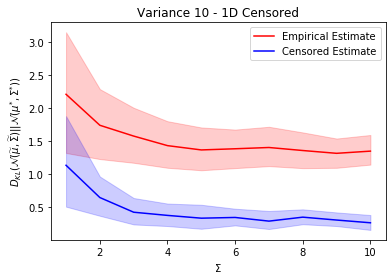

In [54]:
sns.lineplot(data=logs, x='var', y='kl_div_emp', color='red', label='Empirical Estimate')
ax = sns.lineplot(data=logs, x='var', y='kl_div_censored', color='blue', label='Censored Estimate')
ax.set_title('Censored Normal Varying Distribution Variance')
ax.set_xlabel('$\Sigma$')
ax.set_ylabel('$D_{KL}(\mathcal{N}(\widetilde{\mu}, \widetilde{\Sigma}) || \mathcal{N}(\mu^{*}, \Sigma^{*}))$')
ax.set_title('Variance 10 - 1D Censored')
ax.legend()
plt.show()

In [54]:
gt_dist = MultivariateNormal(ch.zeros(1) + .5, ch.ones(1, 1))

In [21]:
gt_loc

tensor(0.1174)

In [62]:
censored.scale

tensor([[0.5863]])